In [2]:
!pip install --no-deps bitsandbytes accelerate xformers==0.0.27.post2 peft trl triton==3.1.0
!pip install --no-deps cut_cross_entropy unsloth_zoo
!pip install sentencepiece protobuf datasets huggingface_hub hf_transfer openai-whisper soundfile librosa jiwer pydantic
!pip install --no-deps unsloth evaluate ffmpeg optuna rouge_score bert_score
!pip install flash-attn --no-build-isolation --no-cache-dir

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 7.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 63.9 MB/s et

In [3]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("Device Name:", torch.cuda.get_device_name(0))

CUDA Available: True
Device Name: NVIDIA A100-SXM4-40GB


# Обработка данных и подготовка датасетов

## Шаг 1: Сокращённый датасет Golos для WhisperAI

In [4]:
import gc
import unicodedata
import re
import os
import numpy as np
import torchaudio
import torch
from torchaudio import transforms
from transformers import WhisperFeatureExtractor, WhisperTokenizer, WhisperProcessor
from datasets import DatasetDict, Dataset, load_dataset

# Загружаем экстрактор признаков и токенизатор для Whisper
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-small")

# Определяем константы
target_sample_rate = feature_extractor.sampling_rate  # Должно быть 16000 Гц для Whisper
max_feature_len = 3000  # Максимальная длина признаков (регулируется в зависимости от датасета)
max_token_length = 448  # Максимальная длина токенов (настраивается при необходимости)

def preprocess_function(batch, split):

    """
    Обрабатывает пакет аудиофайлов и соответствующих текстов.

    Параметры:
    - batch (dict): Пакет данных с путями к аудиофайлам и текстами.
    - split (str): Название набора данных ("train" или "test").

    Возвращает:
    - dict: Словарь с обработанными признаками и токенизированными метками.
    """
    input_features, labels = [], []

    for file_path, text in zip(batch["audio_filepath"], batch["text"]):
        try:
            full_path = os.path.join(golos_dir, f"{split}_opus", file_path)
            if not os.path.exists(full_path):
                continue  # Пропускаем отсутствующие файлы

            # Загружаем и ресемплируем аудиофайл
            waveform, sample_rate = torchaudio.load(full_path)
            if sample_rate != target_sample_rate:
                waveform = transforms.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)(waveform)

            # Преобразуем стерео в моно
            if waveform.shape[0] > 1:
                waveform = waveform.mean(dim=0, keepdim=True)

            # Извлекаем лог-мел спектрограмму
            features = feature_extractor(
                waveform.numpy(), sampling_rate=target_sample_rate, return_tensors="np"
            ).input_features[0]

            # Обрезаем или дополняем спектрограмму
            if features.shape[1] > max_feature_len:
                features = features[:, :max_feature_len]  # Обрезаем
            else:
                pad_width = max_feature_len - features.shape[1]
                features = np.pad(features, ((0, 0), (0, pad_width)), mode="constant")  # Дополняем

            # Токенизируем текстовые метки
            tokenized_labels = tokenizer(
                text, return_tensors="np", padding="max_length", truncation=True, max_length=max_token_length
            ).input_ids[0]

            input_features.append(features.astype(np.float16))
            labels.append(tokenized_labels.astype(np.int64))

        except Exception as e:
            print(f"Пропускаем {file_path}: {str(e)}")
            continue

    return {"input_features": input_features, "labels": labels}

# Определяем путь к датасету Golos
golos_dir = "./sample_datasets/sample_golos/"
train_jsonl_path = os.path.join(golos_dir, "train_opus", "manifest.jsonl")
test_jsonl_path = os.path.join(golos_dir, "test_opus", "manifest.jsonl")

print("Загружаем датасет Golos ...")
dataset_whisper = load_dataset("json", data_files={"train": train_jsonl_path, "validation": test_jsonl_path})

def normalize_text(text):
    """
    Нормализует текстовые данные.

    Параметры:
    - text (str): Исходный текст.

    Возвращает:
    - str: Нормализованный текст.
    """
    text = unicodedata.normalize("NFC", text)  # Приводим к Unicode NFC
    text = text.lower()  # Приводим к нижнему регистру
    text = re.sub(r"[^\w\s']", "", text)  # Удаляем пунктуацию (кроме апострофов)
    text = re.sub(r"\s+", " ", text).strip()  # Убираем лишние пробелы
    return text

def is_valid_text(example):
    """
    Проверяет, содержит ли текст осмысленное содержимое.

    Параметры:
    - example (dict): Запись из датасета.

    Возвращает:
    - bool: True, если текст не пустой.
    """
    return bool(example["text"].strip())

# Загружаем процессор Whisper для русского языка
model_name = "openai/whisper-small"
processor = WhisperProcessor.from_pretrained(model_name, language="russian", task="transcribe")

# Фильтруем датасет, удаляя пустые записи
dataset_whisper["train"] = dataset_whisper["train"].filter(is_valid_text)
dataset_whisper["validation"] = dataset_whisper["validation"].filter(is_valid_text)

# Применяем нормализацию текста
dataset_whisper["train"] = dataset_whisper["train"].map(lambda x: {"text": normalize_text(x["text"])} )
dataset_whisper["validation"] = dataset_whisper["validation"].map(lambda x: {"text": normalize_text(x["text"])} )

# Применяем обработку аудиофайлов к датасету
dataset_whisper["train"] = dataset_whisper["train"].map(
    lambda x: preprocess_function(x, "train"),
    num_proc=1,
    remove_columns=["audio_filepath", "text", "id", "duration"],
    batched=True,
    batch_size=1
)

dataset_whisper["validation"] = dataset_whisper["validation"].map(
    lambda x: preprocess_function(x, "test"),
    num_proc=1,
    remove_columns=["audio_filepath", "text", "id", "duration"],
    batched=True,
    batch_size=1
)

# Устанавливаем формат хранения датасета
dataset_whisper.set_format(type="numpy", columns=["input_features", "labels"])

# Определяем путь для сохранения обработанного датасета
dataset_save_dir = "./sample_datasets/whisper"
dataset_whisper.save_to_disk(dataset_save_dir)
print("Датасет успешно обработан и сохранен!")

print(f'Количество записей в train: {len(dataset_whisper["train"])})')
print(f'Количество записей в test: {len(dataset_whisper["validation"])})')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

Загружаем датасет Golos ...


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Filter:   0%|          | 0/10 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2 [00:00<?, ? examples/s]

Датасет успешно обработан и сохранен!
Количество записей в train: 10)
Количество записей в test: 2)


In [5]:
# Очистка памяти
import gc

del dataset_whisper
del processor

gc.collect()

193

## Шаг 2: Датасет транскрипций и описаний рабочих встреч для DeepSeek R1

In [6]:
import json
import re
import random
from datasets import DatasetDict, Dataset
from transformers import AutoTokenizer

# Максимальная длина последовательности для модели
max_seq_length = 16_384

# Пути к файлам
dataset_path = "./sample_datasets/sample_meeting/meeting.jsonl"
dataset_save_dir = "./sample_datasets/processed_dataset_r1"

# Загружаем данные из JSONL-файла
with open(dataset_path, "r", encoding="utf-8") as f:
    data = [json.loads(line) for line in f]

# Очищаем input_text от HTML-тегов
for entry in data:
    entry["input_text"] = re.sub(r"<[^>]+>", "", entry["input_text"])

print(f"Загружено {len(data)} образцов из JSONL-файла.")

# Перемешиваем датасет
random.seed(42)
random.shuffle(data)

# Разделяем датасет: 90% для обучения, 10% для валидации
split_index = int(len(data) * 0.9)
train_data = data[:split_index]
valid_data = data[split_index:]

# Загружаем токенизатор
model_name = "unsloth/DeepSeek-R1-Distill-Llama-8B-unsloth-bnb-4bit"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Шаблон промпта
prompt_template = """
    Analyze the following meeting transcript and extract the key points:
    1. **Summarization** – a brief summary of the meeting.
    2. **Topics** – a list of topics discussed.
    3. **Decisions** – key decisions made.
    4. **Problems** – challenges or issues identified.
    5. **Actions** – planned or taken actions.

    Return the output **STRICTLY in the following JSON format**:
    {{
      "Summarization": "Brief meeting summary...",
      "Topics": ["Topic 1", "Topic 2"],
      "Actions": ["Action 1", "Action 2"],
      "Problems": ["Problem 1", "Problem 2"],
      "Decisions": ["Decision 1", "Decision 2"]
    }}

    Meeting transcript (in Russian):
    {}

    **Return only a valid JSON response in Russian language.**
    **Do not include explanations, introductions, or extra text.**
    **If a category is missing, return an empty array [].**

    ### Response:
    {}
"""

EOS_TOKEN = tokenizer.eos_token  # Специальный токен конца последовательности

def split_text(text, max_tokens, overlap=500):
    """
    Разбивает длинный текст на чанки, сохраняя перекрытие для контекста.

    Параметры:
    - text (str): Исходный текст.
    - max_tokens (int): Максимальное количество токенов в чанке.
    - overlap (int): Количество перекрывающихся токенов между чанками.

    Возвращает:
    - list: Список чанков текста.
    """
    tokens = tokenizer.tokenize(text)
    chunks = []
    start = 0

    while start < len(tokens):
        end = min(start + max_tokens, len(tokens))
        chunk = tokenizer.convert_tokens_to_string(tokens[start:end])
        chunks.append(chunk)
        start += max_tokens - overlap  # Перекрытие контекста

    return chunks

def formatting_prompts_func(examples):
    """
    Форматирует данные, применяя шаблон промпта.

    Параметры:
    - examples (dict): Словарь с входным и выходным текстом.

    Возвращает:
    - dict: Словарь с форматированными текстами для обучения.
    """
    meeting_transcriptions = examples["input_text"]
    outputs = examples["output_text"]

    texts = []
    for meeting_transcription, output in zip(meeting_transcriptions, outputs):
        # Вычисляем количество токенов в шаблоне промпта и выходном тексте
        prompt_output_length = len(tokenizer.tokenize(prompt_template.format("", output)))
        max_allowed_tokens = max_seq_length - prompt_output_length - 50  # Оставляем запас на EOS

        # Проверяем длину входного текста
        input_tokens = len(tokenizer.tokenize(meeting_transcription))

        if input_tokens > max_allowed_tokens:
            # Разбиваем длинный текст на чанки
            chunks = split_text(meeting_transcription, max_tokens=max_allowed_tokens)
            for chunk in chunks:
                text = prompt_template.format(chunk, output) + EOS_TOKEN
                texts.append(text)
        else:
            # Если текст помещается в ограничение, используем его без изменений
            text = prompt_template.format(meeting_transcription, output) + EOS_TOKEN
            texts.append(text)

    return {"text": texts}

# Создаем датасет в формате DatasetDict
dataset_r1 = DatasetDict({
    "train": Dataset.from_list(train_data),
    "validation": Dataset.from_list(valid_data),
})

# Применяем форматирование к датасету
dataset_r1 = dataset_r1.map(formatting_prompts_func, batched=True)
print("Датасет успешно отформатирован!")

# Сохраняем обработанный датасет на диск
dataset_r1.save_to_disk(dataset_save_dir)
print("Датасет успешно обработан и сохранен!")

print(f'Количество записей в train: {len(dataset_r1["train"])}')
print(f'Количество записей в validation: {len(dataset_r1["validation"])}')

Загружено 10 образцов из JSONL-файла.


tokenizer_config.json:   0%|          | 0.00/53.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Датасет успешно отформатирован!


Saving the dataset (0/1 shards):   0%|          | 0/9 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Датасет успешно обработан и сохранен!
Количество записей в train: 9
Количество записей в validation: 1


In [7]:
# Чистка памяти
import gc

del dataset_r1
del tokenizer

gc.collect()

246

# Обучение моделей

## Шаг 1: Обучение WhisperAI

Функция загрузки модели и примения LoRA

In [8]:
import torch
import torch.nn as nn
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from peft import get_peft_model, PeftModel, LoraConfig, PeftModel

class LoRALayer(nn.Module):
    """
    Реализация LoRA (Low-Rank Adaptation) для линейных слоев.

    Параметры:
    - base_layer (nn.Module): Исходный линейный слой.
    - r (int): Ранг разложения LoRA (по умолчанию 8).
    - alpha (int): Коэффициент масштабирования (по умолчанию 32).
    - dropout (float): Вероятность dropout между LoRA-матрицами (по умолчанию 0.2).

    Описание:
    - Разлагает линейный слой на две дополнительные матрицы (A и B).
    - Применяет dropout между матрицами для регуляризации.
    - После обработки LoRA-слой суммируется с выходом оригинального слоя.
    """

    def __init__(self, base_layer, r=8, alpha=32, dropout=0.2):
        super().__init__()
        self.base_layer = base_layer  # Оригинальный слой
        self.r = r  # Ранг разложения
        self.scaling = alpha / r  # Масштабный коэффициент

        # Создаем матрицы LoRA A и B
        self.lora_A = nn.Linear(base_layer.in_features, r, bias=False)
        self.lora_B = nn.Linear(r, base_layer.out_features, bias=False)

        # Добавляем dropout между матрицами A и B
        self.dropout = nn.Dropout(p=dropout)

        # Инициализируем веса LoRA
        nn.init.kaiming_uniform_(self.lora_A.weight)  # Xavier инициализация
        nn.init.zeros_(self.lora_B.weight)  # Обнуляем веса B

    def forward(self, x):
        """
        Применяет LoRA-обработку к входным данным.

        Параметры:
        - x (Tensor): Входные данные.

        Возвращает:
        - Tensor: Результат суммирования оригинального слоя и LoRA.
        """
        return self.base_layer(x) + self.lora_B(self.lora_A(x)) * self.scaling


def load_whisper_with_lora(
    model_name="openai/whisper-tiny",
    r=8,
    alpha=32,
    dropout=0.2
):
    """
    Загружает модель Whisper и применяет LoRA с использованием LoRA.

    Параметры:
    - model_name (str): Название модели Whisper (по умолчанию "openai/whisper-tiny").
    - r (int): Ранг LoRA (по умолчанию 8).
    - alpha (int): Коэффициент масштабирования (по умолчанию 32).
    - dropout (float): Вероятность dropout между LoRA-слоями (по умолчанию 0.2).

    Возвращает:
    - model_whisper (WhisperForConditionalGeneration): Модифицированная модель Whisper.
    - processor (WhisperProcessor): Процессор модели для обработки входных данных.
    """
    # Загружаем процессор и модель Whisper
    processor = WhisperProcessor.from_pretrained(model_name)
    model_whisper = WhisperForConditionalGeneration.from_pretrained(model_name)

    # Принудительное использование русского языка в декодере
    model_whisper.config.forced_decoder_ids = processor.get_decoder_prompt_ids(language="russian", task="transcribe")

    # Применяем LoRA ко всем линейным слоям, которые участвуют в обработке входных данных
    for name, module in model_whisper.named_modules():
        if isinstance(module, nn.Linear) and any(k in name for k in ["q_proj", "v_proj", "k_proj", "out_proj", "fc1", "fc2"]):
            parent = model_whisper.get_submodule(".".join(name.split(".")[:-1]))  # Получаем родительский модуль
            setattr(parent, name.split(".")[-1], LoRALayer(module, r=r, alpha=alpha, dropout=dropout))  # Заменяем слой

    print("LoRA успешно применена к модели Whisper!")
    print(f"Количество тренируемых параметров: {sum(p.numel() for p in model_whisper.parameters() if p.requires_grad)}")

    return model_whisper, processor

Базовый DataCollator

In [9]:
import torch
import numpy as np
from torch.nn.utils.rnn import pad_sequence

class WhisperDataCollator:
    """
    Класс для подготовки batch'а данных для модели Whisper.

    Параметры:
    - feature_extractor: Объект экстрактора признаков (WhisperFeatureExtractor).

    Описание:
    - Выполняет обработку данных перед передачей в модель.
    - Приводит логмел-спектрограммы и метки к одинаковой длине (паддинг).
    """

    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor

    def __call__(self, features):
        """
        Обрабатывает batch данных, применяя паддинг к спектрограммам и меткам.

        Параметры:
        - features (list[dict]): Список примеров, содержащих "input_features" и "labels".

        Возвращает:
        - dict: Готовый batch для передачи в модель Whisper.
            - "input_features" (Tensor): Паддинговые логмел-спектрограммы.
            - "labels" (Tensor): Паддинговые токенизированные метки.
        """
        # Извлекаем признаки (логмел-спектрограммы) и метки (labels)
        input_features = [torch.tensor(f["input_features"], dtype=torch.float16) for f in features]
        labels = [torch.tensor(f["labels"], dtype=torch.int64) for f in features]

        # Выполняем паддинг логмел-спектрограмм до одинаковой длины
        input_features = pad_sequence(input_features, batch_first=True, padding_value=0.0)

        # Выполняем паддинг labels (используем padding_value=-100 для игнорирования при расчёте потерь)
        labels = pad_sequence(labels, batch_first=True, padding_value=-100)

        return {
            "input_features": input_features,  # Подготовленные спектрограммы для Whisper
            "labels": labels  # Метки для обучения
        }

Аугментация

In [10]:
import torch
import random
import torchaudio.transforms as T
import numpy as np
from torch.nn.utils.rnn import pad_sequence

def augment_audio(audio_tensor):
    """
    Применяет случайные аугментации к аудиоданным и возвращает модифицированное аудио.

    Параметры:
    - audio_tensor (numpy.ndarray или Tensor): Входной аудиосигнал.

    Возвращает:
    - numpy.ndarray: Аудиосигнал после применения случайных преобразований.

    Описание:
    - Добавляет случайный шум с вероятностью 50%.
    - Изменяет громкость с вероятностью 50%.
    - Применяет маскирование частот с вероятностью 50%.
    - Применяет маскирование по времени с вероятностью 50%.
    """

    # Преобразуем входной массив в тензор Torch
    audio_tensor = torch.tensor(audio_tensor)

    # Добавление случайного шума
    if torch.rand(1).item() > 0.5:
        noise = torch.randn_like(audio_tensor) * 0.02  # Генерация шума
        audio_tensor += noise  # Добавляем шум к сигналу

    # Изменение громкости
    if torch.rand(1).item() > 0.5:
        audio_tensor = T.Vol(gain=torch.rand(1).item() * 0.4 + 0.8)(audio_tensor)  # Изменение громкости в пределах [0.8, 1.2]

    # Маскирование частотных компонентов
    if torch.rand(1).item() > 0.5:
        audio_tensor = T.FrequencyMasking(freq_mask_param=10)(audio_tensor)  # Закрываем случайные частоты

    # Маскирование по времени
    if torch.rand(1).item() > 0.5:
        audio_tensor = T.TimeMasking(time_mask_param=10)(audio_tensor)  # Закрываем случайные временные интервалы

    return audio_tensor.numpy()  # Преобразуем обратно в массив NumPy

Функция подготовки обучения модели

In [11]:
import torch
import torch.backends.cudnn
import gc
import jiwer
import re
import unicodedata
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from torch.utils.data import RandomSampler
from accelerate import Accelerator

def train_whisper(
    dataset_whisper,
    model_whisper,  # Модель Whisper
    processor,  # Токенизатор Whisper
    data_collator,
    training_args
):
    """
    Обучает модель Whisper на заданном датасете.

    Параметры:
    - dataset_whisper (DatasetDict): Датасет с обучающим и валидационным наборами.
    - model_whisper (WhisperForConditionalGeneration): Предварительно загруженная модель Whisper.
    - processor (WhisperProcessor): Процессор для обработки аудиоданных.
    - data_collator (DataCollator): Функция подготовки батчей данных.
    - training_args (TrainingArguments): Аргументы для обучения.

    Возвращает:
    - Trainer: Обученный объект Trainer.

    Описание:
    - Отключает кеширование и градиентный чекпоинтинг.
    - Подключает `Accelerator` для оптимизации обучения.
    - Создаёт объект `Trainer` для обучения модели.
    - Очищает память перед обучением, чтобы избежать утечек.
    - Запускает процесс обучения модели.
    """

    # Отключаем кеш и градиентный чекпоинтинг для экономии памяти
    model_whisper.config.use_cache = False
    model_whisper.config.gradient_checkpointing = False

    # Подключаем `Accelerator` для автоматического распределения вычислений
    accelerator = Accelerator()
    model_whisper, dataset_whisper["train"], dataset_whisper["validation"] = accelerator.prepare(
        model_whisper, dataset_whisper["train"], dataset_whisper["validation"]
    )

    # Создаём Trainer для обучения модели Whisper
    trainer = Trainer(
        model=model_whisper,
        args=training_args,
        train_dataset=dataset_whisper["train"],
        eval_dataset=dataset_whisper["validation"],
        data_collator=data_collator,
        processing_class=processor.feature_extractor,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Ранний стоп при отсутствии улучшений
    )

    # Очистка кеша и памяти перед началом обучения
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.reset_accumulated_memory_stats()

    # Вывод информации об используемой памяти GPU
    print(f"Всего памяти GPU: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"Свободная память GPU: {torch.cuda.memory_reserved() / 1e9:.2f} GB")
    print(f"Используемая память GPU: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

    # Запускаем обучение
    trainer.train()

    print("Обучение завершено.")

    return trainer

Функция подсчёта метрики WER

In [12]:
# Определяем функцию для вычисления WER (Word Error Rate)
def compute_wer(model, processor, dataset, sample_size=100):
    """
    Вычисляет коэффициент ошибок слов (WER) для заданного датасета.

    Параметры:
    - model (WhisperForConditionalGeneration): Модель Whisper для инференса.
    - processor (WhisperProcessor): Процессор Whisper для декодирования текста.
    - dataset (Dataset): Датасет, на котором проводится оценка (например, dataset_whisper["validation"]).
    - sample_size (int): Количество примеров для вычисления WER (по умолчанию: 100).

    Возвращает:
    - wer_score (float): Итоговый коэффициент ошибок слов (WER).

    Описание:
    - Берёт случайную выборку из датасета.
    - Пропускает аудиоданные через модель и получает предсказания.
    - Декодирует предсказания и исходные тексты.
    - Сравнивает предсказания с оригинальными текстами и вычисляет WER.
    """

    predictions = []  # Список предсказаний модели
    references = []  # Список эталонных (правильных) текстов

    # Выбираем подмножество данных для оценки
    for batch in dataset.select(range(sample_size)):
        # Преобразуем входные признаки в тензор нужной формы и переносим на устройство модели
        input_features = batch["input_features"].unsqueeze(0).to(model.device)

        with torch.no_grad():  # Отключаем градиенты для ускорения инференса
            output_tokens = model.generate(input_features)  # Генерируем предсказанные токены

        # Декодируем предсказанный текст
        predicted_text = processor.batch_decode(output_tokens, skip_special_tokens=True)[0]
        predictions.append(predicted_text)

        # Декодируем истинный текст (ground truth)
        reference_text = processor.batch_decode([batch["labels"]], skip_special_tokens=True)[0]
        references.append(reference_text)

    # Вычисляем WER, сравнивая эталонные тексты с предсказанными
    wer_score = jiwer.wer(reference=references, hypothesis=predictions)
    return wer_score  # Возвращаем итоговый WER

Функция анализа и вывода метрик

In [20]:
import os
import gc
import pandas as pd
import matplotlib.pyplot as plt

def save_metrics_and_evaluate_whisper(trainer, experiment_id, model_whisper, processor, dataset_whisper, sample_size=100):
    """
    Сохраняет метрики обучения, строит графики и вычисляет WER.

    Параметры:
    - trainer (Trainer): Обученный экземпляр модели.
    - experiment_id (int): Номер эксперимента (используется для именования файлов).
    - model_whisper (WhisperForConditionalGeneration): Модель Whisper для инференса.
    - processor (WhisperProcessor): Токенизатор Whisper.
    - dataset_whisper (DatasetDict): Датасет с валидационным набором данных.

    Возвращает:
    - None (Сохраняет CSV-файл с метриками и строит график).

    Описание:
    - Извлекает данные об обучении (loss на train и validation).
    - Определяет стратегию валидации (по шагам или по эпохам).
    - Строит и сохраняет график потерь обучения.
    - Вычисляет WER на валидационном наборе.
    - Очищает память после вычислений.
    """

    # Определяем стратегию валидации
    eval_strategy = trainer.args.eval_strategy  # 'epoch' или 'steps'
    eval_steps = trainer.args.eval_steps  # Количество шагов между валидациями
    num_epochs = int(trainer.args.num_train_epochs)  # Общее количество эпох

    train_losses = []
    val_losses = []
    valid_steps = []

    if eval_strategy == "steps":
        # Создаём словари для хранения значений loss
        step_train_loss = {}  # Словарь для train_loss
        step_eval_loss = {}   # Словарь для eval_loss

        # Обрабатываем логи обучения
        for log in trainer.state.log_history:
            step = log.get("step", None)
            if step is None:
                continue

            if "loss" in log:
                step_train_loss[step] = log["loss"]  # Сохраняем train loss на этом шаге
            if "eval_loss" in log:
                step_eval_loss[step] = log["eval_loss"]  # Сохраняем eval loss на этом шаге

        # Выбираем только те шаги, для которых есть и train_loss, и eval_loss
        valid_steps = sorted(set(step_train_loss.keys()) & set(step_eval_loss.keys()))

        # Извлекаем значения train_loss и eval_loss только для валидных шагов
        train_losses = [step_train_loss[step] for step in valid_steps]
        val_losses = [step_eval_loss[step] for step in valid_steps]

    elif eval_strategy == "epoch":
        # Фильтруем логи, содержащие eval_loss
        eval_logs = [log for log in trainer.state.log_history if "eval_loss" in log]

        # Обрабатываем логи и выравниваем train_loss с eval_loss
        for eval_log in eval_logs:
            step_or_epoch = eval_log["step"] if eval_strategy == "steps" else int(eval_log["epoch"])
            val_loss = eval_log["eval_loss"]

            # Ищем последнее значение train_loss перед данной точкой
            train_loss = None
            for train_log in reversed(trainer.state.log_history):
                if "loss" in train_log and train_log["step"] <= eval_log["step"]:
                    train_loss = train_log["loss"]
                    break

            if train_loss is not None:
                valid_steps.append(step_or_epoch)
                train_losses.append(train_loss)
                val_losses.append(val_loss)

    # Создаём DataFrame с метриками обучения
    metrics_df = pd.DataFrame({
        "step_or_epoch": valid_steps,
        "train_loss": train_losses,
        "val_loss": val_losses
    })

    # Сохраняем данные в CSV
    save_dir = "./outputs"
    os.makedirs(save_dir, exist_ok=True)
    csv_path = f"{save_dir}/whisper_training_losses_experiment_{experiment_id}.csv"
    metrics_df.to_csv(csv_path, index=False)
    print(f"Обучение завершено. Метрики сохранены в {csv_path}")

    # Строим график Training & Validation Loss
    plt.figure(figsize=(10, 5))
    plt.plot(metrics_df["step_or_epoch"], metrics_df["train_loss"], label="Train Loss", marker="o")
    plt.plot(metrics_df["step_or_epoch"], metrics_df["val_loss"], label="Validation Loss", marker="o")
    plt.xlabel("Epoch" if eval_strategy == "epoch" else "Steps")
    plt.ylabel("Loss")
    plt.title(f"Training & Validation Loss - Experiment {experiment_id}")
    plt.legend()
    plt.grid()
    plt.show()

    # Вычисляем WER на валидационном наборе
    print("Подсчёт WER на валидационном датасете...")
    model_whisper.eval()
    wer_score = compute_wer(model_whisper, processor, dataset_whisper["validation"], sample_size=sample_size)
    print(f"WER: {wer_score:.4f}")

    # Очищаем память
    del metrics_df, wer_score
    gc.collect()

Функция очистки памяти

In [14]:
import gc
import torch

def clean_memory(variables_to_delete):
    """
    Очищает память, удаляя указанные переменные и освобождая GPU.

    Параметры:
    - variables_to_delete (list[str]): Список имён переменных, которые нужно удалить.

    Возвращает:
    - None (Очищает память и выводит сообщение о завершении).

    Описание:
    - Проверяет, существуют ли указанные переменные в `globals()`.
    - Удаляет найденные переменные.
    - Запускает сборщик мусора `gc.collect()` для очистки оперативной памяти.
    - Очищает кэш CUDA с помощью `torch.cuda.empty_cache()`, освобождая видеопамять.
    """

    # Проверяем наличие переменных и удаляем их
    for var in variables_to_delete:
        if var in globals():
            del globals()[var]
            print(f"Удалено: {var}")

    # Запускаем очистку памяти
    gc.collect()  # Сборщик мусора Python
    torch.cuda.empty_cache()  # Очистка видеопамяти GPU
    print("Очистка памяти выполнена успешно!")

### Оценка модели до обучения

In [15]:
from datasets import load_from_disk

dataset_whisper = load_from_disk("./sample_datasets/whisper")
print(dataset_whisper)

dataset_whisper.set_format(type="torch", columns=["input_features", "labels"])
print(type(dataset_whisper["train"][0]["input_features"]))
print(type(dataset_whisper["train"][0]["labels"]))

DatasetDict({
    train: Dataset({
        features: ['input_features', 'labels'],
        num_rows: 10
    })
    validation: Dataset({
        features: ['input_features', 'labels'],
        num_rows: 2
    })
})
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [19]:
import torch
from transformers import WhisperProcessor, WhisperForConditionalGeneration

model_name = "openai/whisper-tiny"
processor = WhisperProcessor.from_pretrained(model_name)
model_whisper = WhisperForConditionalGeneration.from_pretrained(model_name)
model_whisper.config.forced_decoder_ids = processor.get_decoder_prompt_ids(language="russian", task="transcribe")

print("Подсчёт WER на валидационном датасете...")
model_whisper.eval()
wer_score = compute_wer(model_whisper, processor, dataset_whisper["validation"],sample_size=2)
print(f"WER: {wer_score:.4f}")

clean_memory(["dataset_whisper", "model_whisper", "processor", "wer_score"])

Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.


Подсчёт WER на валидационном датасете...


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


WER: 0.8571
Удалено: dataset_whisper
Удалено: model_whisper
Удалено: processor
Удалено: wer_score
Очистка памяти выполнена успешно!


### Эксперимент 1: openai/whisper-tiny + Trainer (learning rate=1e-5)

Загрузка датасета

In [21]:
from datasets import load_from_disk

dataset_whisper = load_from_disk("./sample_datasets/whisper")
print(dataset_whisper)

dataset_whisper.set_format(type="torch", columns=["input_features", "labels"])
print(type(dataset_whisper["train"][0]["input_features"]))
print(type(dataset_whisper["train"][0]["labels"]))

DatasetDict({
    train: Dataset({
        features: ['input_features', 'labels'],
        num_rows: 10
    })
    validation: Dataset({
        features: ['input_features', 'labels'],
        num_rows: 2
    })
})
<class 'torch.Tensor'>
<class 'torch.Tensor'>


Загрузка модели для обучения

In [22]:
import torch
from transformers import WhisperProcessor, WhisperForConditionalGeneration

model_name = "openai/whisper-tiny"
processor = WhisperProcessor.from_pretrained(model_name)
model_whisper = WhisperForConditionalGeneration.from_pretrained(model_name)
model_whisper.config.forced_decoder_ids = processor.get_decoder_prompt_ids(language="russian", task="transcribe")

In [23]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./models/whisper-finetuned-ru",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,
    eval_strategy="steps",
    eval_steps=200,
    save_strategy="steps",
    save_steps=1000,
    save_total_limit=2,
    learning_rate=1e-5,
    warmup_steps=10,
    logging_dir="./outputs/logs",
    logging_steps=10,
    fp16=True,
    push_to_hub=False,
    report_to="none",
    load_best_model_at_end = True,
    metric_for_best_model="eval_loss"
)

data_collator = WhisperDataCollator(processor)

In [24]:
trainer=train_whisper(dataset_whisper, model_whisper, processor, data_collator, training_args)

Всего памяти GPU: 42.47 GB
Свободная память GPU: 0.18 GB
Используемая память GPU: 0.15 GB


<ipython-input-9-e62e31a29de2>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_features = [torch.tensor(f["input_features"], dtype=torch.float16) for f in features]
<ipython-input-9-e62e31a29de2>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = [torch.tensor(f["labels"], dtype=torch.int64) for f in features]


Step,Training Loss,Validation Loss


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:2758: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50359, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Обучение завершено.


Обучение завершено. Метрики сохранены в ./outputs/whisper_training_losses_experiment_1.csv


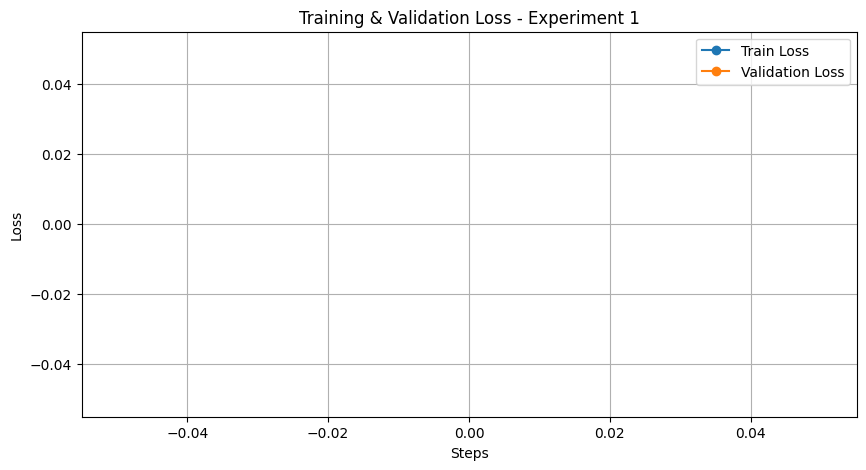

Подсчёт WER на валидационном датасете...
WER: 0.8571


In [25]:
experiment_id = 1
save_metrics_and_evaluate_whisper(trainer, experiment_id, model_whisper, processor, dataset_whisper, sample_size=2)

In [26]:
clean_memory(["dataset_whisper", "model_whisper", "processor", "data_collator", "trainer", "training_args"])

Удалено: dataset_whisper
Удалено: model_whisper
Удалено: processor
Удалено: data_collator
Удалено: trainer
Удалено: training_args
Очистка памяти выполнена успешно!


### Эксперимент 2: openai/whisper-tiny + LoRA (r=8, alpha=32, dropout=0.2)

In [27]:
from datasets import load_from_disk

dataset_whisper = load_from_disk("./sample_datasets/whisper")
print(dataset_whisper)

dataset_whisper.set_format(type="torch", columns=["input_features", "labels"])
print(type(dataset_whisper["train"][0]["input_features"]))
print(type(dataset_whisper["train"][0]["labels"]))

DatasetDict({
    train: Dataset({
        features: ['input_features', 'labels'],
        num_rows: 10
    })
    validation: Dataset({
        features: ['input_features', 'labels'],
        num_rows: 2
    })
})
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [28]:
model_whisper, processor = load_whisper_with_lora(model_name="openai/whisper-tiny", r=8, alpha=32, dropout=0.2)

LoRA успешно применена к модели Whisper!
Количество тренируемых параметров: 37725312


In [29]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./models/whisper-finetuned-ru",
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    eval_strategy="steps",
    eval_steps=200,
    save_strategy="steps",
    save_steps=1000,
    save_total_limit=2,
    learning_rate=1e-5,
    warmup_steps=10,
    logging_dir="./outputs/logs",
    logging_steps=10,
    fp16=True,
    push_to_hub=False,
    report_to="none",
    load_best_model_at_end = True,
    metric_for_best_model="eval_loss"
)
data_collator = WhisperDataCollator(processor)

In [30]:
trainer=train_whisper(dataset_whisper, model_whisper, processor, data_collator, training_args)

Всего памяти GPU: 42.47 GB
Свободная память GPU: 0.22 GB
Используемая память GPU: 0.17 GB


<ipython-input-9-e62e31a29de2>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_features = [torch.tensor(f["input_features"], dtype=torch.float16) for f in features]
<ipython-input-9-e62e31a29de2>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = [torch.tensor(f["labels"], dtype=torch.int64) for f in features]


Step,Training Loss,Validation Loss


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:2758: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50359, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Обучение завершено.


Обучение завершено. Метрики сохранены в ./outputs/whisper_training_losses_experiment_2.csv


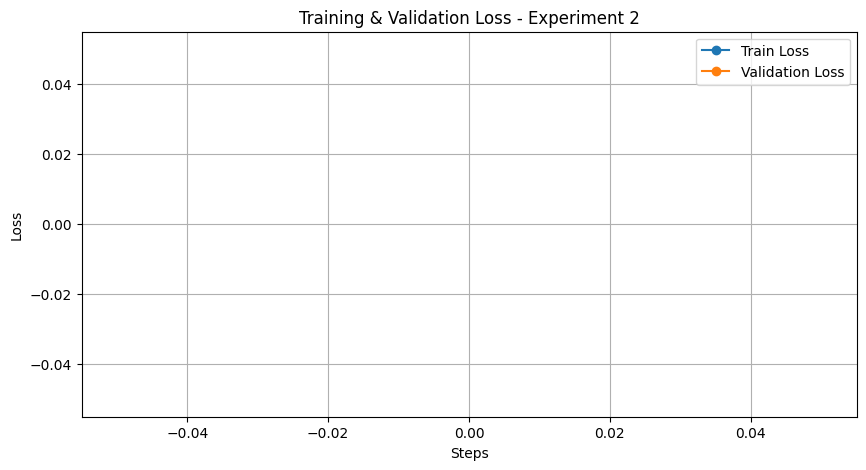

Подсчёт WER на валидационном датасете...
WER: 0.8571


In [31]:
experiment_id = 2
save_metrics_and_evaluate_whisper(trainer, experiment_id, model_whisper, processor, dataset_whisper, sample_size=2)

In [32]:
clean_memory(["dataset_whisper", "model_whisper", "processor", "data_collator", "trainer", "training_args"])

Удалено: dataset_whisper
Удалено: model_whisper
Удалено: processor
Удалено: data_collator
Удалено: trainer
Удалено: training_args
Очистка памяти выполнена успешно!


### Эксперимент 3: openai/whisper-tiny + LoRA (r=16) + Trainer (learning rate=1e-4, weight_decay=0.01, optim="adamw_torch_fused") + увеличение количества эпох до 5

In [33]:
from datasets import load_from_disk

dataset_whisper = load_from_disk("./sample_datasets/whisper")
print(dataset_whisper)

dataset_whisper.set_format(type="torch", columns=["input_features", "labels"])
print(type(dataset_whisper["train"][0]["input_features"]))
print(type(dataset_whisper["train"][0]["labels"]))

DatasetDict({
    train: Dataset({
        features: ['input_features', 'labels'],
        num_rows: 10
    })
    validation: Dataset({
        features: ['input_features', 'labels'],
        num_rows: 2
    })
})
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [34]:
model_whisper, processor = load_whisper_with_lora(model_name="openai/whisper-tiny", r=16, alpha=32, dropout=0.2)

LoRA успешно применена к модели Whisper!
Количество тренируемых параметров: 38265984


In [35]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./models/whisper-finetuned-ru",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=2,
    eval_accumulation_steps=10,
    num_train_epochs=5,
    weight_decay=0.01,
    save_total_limit=2,
    logging_dir="./outputs/logs",
    push_to_hub=False,
    bf16=False,
    fp16=True,
    optim="adamw_torch_fused",
    report_to="none",
    load_best_model_at_end = True,
    metric_for_best_model="eval_loss"
)

data_collator = WhisperDataCollator(processor)

In [36]:
trainer=train_whisper(dataset_whisper, model_whisper, processor, data_collator, training_args)

Всего памяти GPU: 42.47 GB
Свободная память GPU: 0.25 GB
Используемая память GPU: 0.17 GB


<ipython-input-9-e62e31a29de2>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_features = [torch.tensor(f["input_features"], dtype=torch.float16) for f in features]
<ipython-input-9-e62e31a29de2>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = [torch.tensor(f["labels"], dtype=torch.int64) for f in features]


Epoch,Training Loss,Validation Loss
1,No log,11.598813
2,No log,11.598813
3,No log,11.598813
4,No log,11.598813


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:2758: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50359, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
<ipython-input-9-e62e31a29de2>:33: UserWarning: To copy construct from a tensor, it is recommended to use 

Обучение завершено.


Обучение завершено. Метрики сохранены в ./outputs/whisper_training_losses_experiment_3.csv


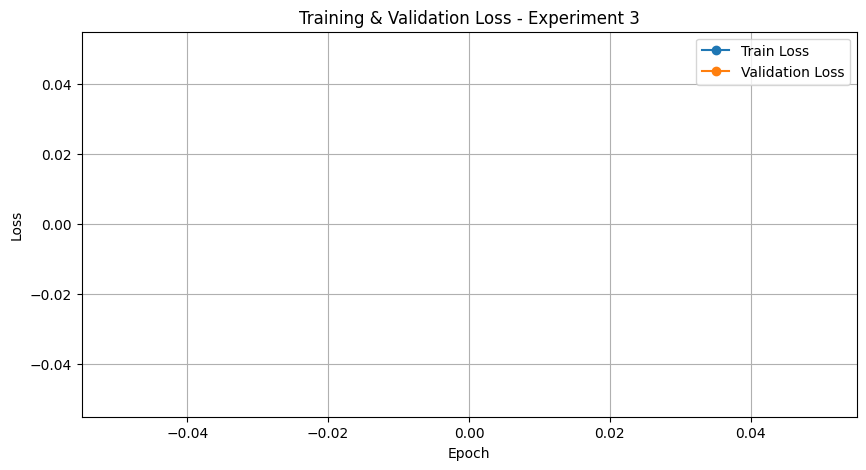

Подсчёт WER на валидационном датасете...
WER: 0.8571


In [37]:
experiment_id = 3
save_metrics_and_evaluate_whisper(trainer, experiment_id, model_whisper, processor, dataset_whisper, sample_size=2)

In [38]:
clean_memory(["dataset_whisper", "model_whisper", "processor", "data_collator", "trainer", "training_args"])

Удалено: dataset_whisper
Удалено: model_whisper
Удалено: processor
Удалено: data_collator
Удалено: trainer
Удалено: training_args
Очистка памяти выполнена успешно!


### Эксперимент 4: openai/whisper-tiny + LoRA + Trainer (learning rate=1e-5, warmup_steps=1000, lr_scheduler_type="cosine") + увеличение количества эпох до 10

In [39]:
from datasets import load_from_disk

dataset_whisper = load_from_disk("./sample_datasets/whisper")
print(dataset_whisper)

dataset_whisper.set_format(type="torch", columns=["input_features", "labels"])
print(type(dataset_whisper["train"][0]["input_features"]))
print(type(dataset_whisper["train"][0]["labels"]))

DatasetDict({
    train: Dataset({
        features: ['input_features', 'labels'],
        num_rows: 10
    })
    validation: Dataset({
        features: ['input_features', 'labels'],
        num_rows: 2
    })
})
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [40]:
model_whisper, processor = load_whisper_with_lora(model_name="openai/whisper-tiny", r=16, alpha=32, dropout=0.2)

LoRA успешно применена к модели Whisper!
Количество тренируемых параметров: 38265984


In [41]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./models/whisper-finetuned-ru",  # Куда сохранять модель
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=2,
    eval_accumulation_steps=10,
    num_train_epochs=10,
    warmup_steps=1000,  # постепенное разогревание
    lr_scheduler_type="cosine",  # косинусный спад
    weight_decay=0.01,
    save_total_limit=2,
    logging_dir="./outputs/logs",
    report_to="none",
    push_to_hub=False,
    bf16=False,
    fp16=True,
    optim="adamw_torch_fused",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss"
)

data_collator = WhisperDataCollator(processor)

In [42]:
trainer=train_whisper(dataset_whisper, model_whisper, processor, data_collator, training_args)

Всего памяти GPU: 42.47 GB
Свободная память GPU: 0.92 GB
Используемая память GPU: 0.17 GB


<ipython-input-9-e62e31a29de2>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_features = [torch.tensor(f["input_features"], dtype=torch.float16) for f in features]
<ipython-input-9-e62e31a29de2>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = [torch.tensor(f["labels"], dtype=torch.int64) for f in features]


Epoch,Training Loss,Validation Loss
1,No log,11.598813
2,No log,11.598813
3,No log,11.598813
4,No log,11.598813


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:2758: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50359, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
<ipython-input-9-e62e31a29de2>:33: UserWarning: To copy construct from a tensor, it is recommended to use 

Обучение завершено.


Обучение завершено. Метрики сохранены в ./outputs/whisper_training_losses_experiment_4.csv


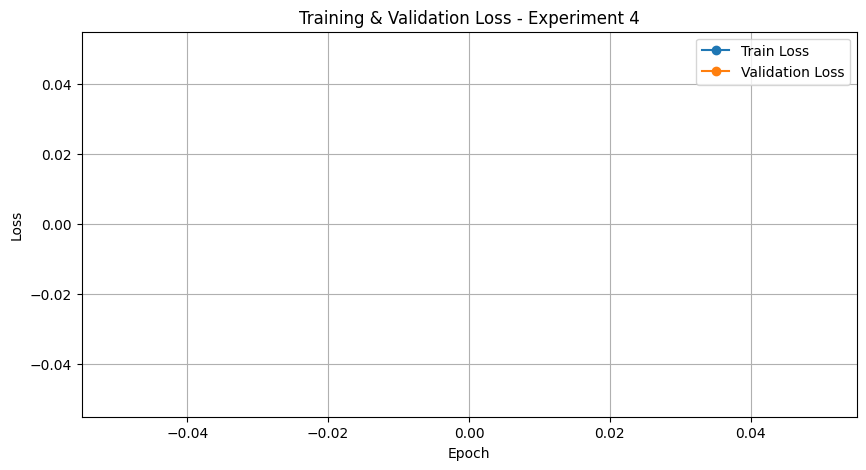

Подсчёт WER на валидационном датасете...
WER: 0.8571


In [43]:
experiment_id = 4
save_metrics_and_evaluate_whisper(trainer, experiment_id, model_whisper, processor, dataset_whisper, sample_size=2)

In [44]:
clean_memory(["dataset_whisper", "model_whisper", "processor", "data_collator", "trainer", "training_args"])

Удалено: dataset_whisper
Удалено: model_whisper
Удалено: processor
Удалено: data_collator
Удалено: trainer
Удалено: training_args
Очистка памяти выполнена успешно!


### Эксперимент 5: openai/whisper-tiny + LoRA + Trainer (max_grad_norm=0.5)  + аугментация

In [45]:
from datasets import load_from_disk, DatasetDict

dataset_whisper = load_from_disk("./sample_datasets/whisper")
print(dataset_whisper)

dataset_whisper.set_format(type="torch", columns=["input_features", "labels"])
print(type(dataset_whisper["train"][0]["input_features"]))
print(type(dataset_whisper["train"][0]["labels"]))

DatasetDict({
    train: Dataset({
        features: ['input_features', 'labels'],
        num_rows: 10
    })
    validation: Dataset({
        features: ['input_features', 'labels'],
        num_rows: 2
    })
})
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [46]:
def preprocess_function(example):
    """Applies augmentation to input features and returns the modified dataset"""
    example["input_features"] = augment_audio(example["input_features"])
    return example

augmented_train_dataset = dataset_whisper["train"].map(
    preprocess_function,
    num_proc=1)

augmented_train_dataset.save_to_disk("./sample_datasets/whisper_augmented")

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

<ipython-input-10-314b1edcded4>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  audio_tensor = torch.tensor(audio_tensor)


Saving the dataset (0/1 shards):   0%|          | 0/10 [00:00<?, ? examples/s]

In [47]:
augmented_dataset = DatasetDict({
    "train": augmented_train_dataset,
    "validation": dataset_whisper["validation"]
})

In [48]:
model_whisper, processor = load_whisper_with_lora(model_name="openai/whisper-tiny", r=16, alpha=32, dropout=0.2)

LoRA успешно применена к модели Whisper!
Количество тренируемых параметров: 38265984


In [49]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./models/whisper-finetuned-ru",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end = True,
    save_total_limit=2,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=1,
    eval_accumulation_steps=4,
    num_train_epochs=10,
    lr_scheduler_type="cosine",
    warmup_steps=1000,
    learning_rate=1e-5,
    weight_decay=0.01,
    logging_dir="./outputs/logs",
    logging_steps=10,
    report_to="none",
    push_to_hub=False,
    bf16=False,
    fp16=True,
    optim="adamw_torch_fused",
    max_grad_norm=0.5,
    dataloader_pin_memory=False
)

data_collator = WhisperDataCollator(processor)

In [50]:
trainer=train_whisper(augmented_dataset, model_whisper, processor, data_collator, training_args)

Всего памяти GPU: 42.47 GB
Свободная память GPU: 0.93 GB
Используемая память GPU: 0.17 GB


<ipython-input-9-e62e31a29de2>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_features = [torch.tensor(f["input_features"], dtype=torch.float16) for f in features]
<ipython-input-9-e62e31a29de2>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = [torch.tensor(f["labels"], dtype=torch.int64) for f in features]


Epoch,Training Loss,Validation Loss
1,No log,11.598813
2,11.328700,11.597318
3,11.328700,11.557066
4,11.265600,11.434576
5,11.265600,11.099468
6,10.807300,10.268700
7,10.807300,9.807879
8,9.302800,9.123684
9,9.302800,6.912699
10,6.417400,5.807188


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:2758: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50359, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
<ipython-input-9-e62e31a29de2>:33: UserWarning: To copy construct from a tensor, it is recommended to use 

Обучение завершено.


Обучение завершено. Метрики сохранены в ./outputs/whisper_training_losses_experiment_5.csv


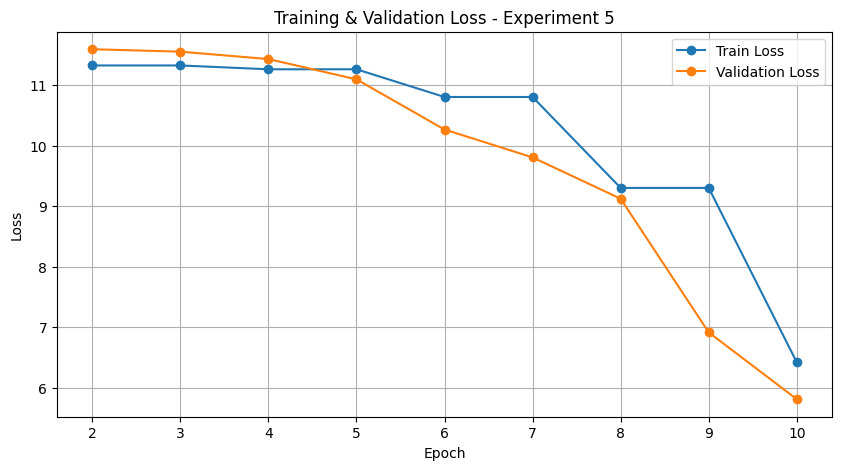

Подсчёт WER на валидационном датасете...
WER: 0.8571


In [51]:
experiment_id = 5
save_metrics_and_evaluate_whisper(trainer, experiment_id, model_whisper, processor, dataset_whisper, sample_size=2)

In [52]:
clean_memory(["dataset_whisper", "model_whisper", "processor", "data_collator", "trainer", "training_args"])

Удалено: dataset_whisper
Удалено: model_whisper
Удалено: processor
Удалено: data_collator
Удалено: trainer
Удалено: training_args
Очистка памяти выполнена успешно!


### Эксперимент 6: openai/whisper-small + LoRA (dropout=0.3) + Trainer (lr_scheduler_type="cosine_with_restarts")

In [53]:
from datasets import load_from_disk
from torch.utils.data import DataLoader

dataset_whisper = load_from_disk("./sample_datasets/whisper")
print(dataset_whisper)

dataset_whisper.set_format(type="torch", columns=["input_features", "labels"])
print(type(dataset_whisper["train"][0]["input_features"]))
print(type(dataset_whisper["train"][0]["labels"]))

DatasetDict({
    train: Dataset({
        features: ['input_features', 'labels'],
        num_rows: 10
    })
    validation: Dataset({
        features: ['input_features', 'labels'],
        num_rows: 2
    })
})
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [54]:
model_whisper, processor = load_whisper_with_lora(model_name="openai/whisper-small", r=16, alpha=32, dropout=0.3)

config.json:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.87k [00:00<?, ?B/s]

LoRA успешно применена к модели Whisper!
Количество тренируемых параметров: 247070976


In [55]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./models/whisper-finetuned-ru",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end = True,
    save_total_limit=2,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=2,
    eval_accumulation_steps=4,
    num_train_epochs=20,
    lr_scheduler_type="cosine_with_restarts",
    warmup_steps=1000,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_dir="./outputs/logs",
    logging_steps=10,
    report_to="none",
    push_to_hub=False,
    bf16=False,
    fp16=True,
    optim="adamw_torch_fused",
    max_grad_norm=0.5,
    dataloader_pin_memory=True
)

data_collator = WhisperDataCollator(processor)

In [56]:
trainer=train_whisper(dataset_whisper, model_whisper, processor, data_collator, training_args)

Всего памяти GPU: 42.47 GB
Свободная память GPU: 1.46 GB
Используемая память GPU: 1.01 GB


<ipython-input-9-e62e31a29de2>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_features = [torch.tensor(f["input_features"], dtype=torch.float16) for f in features]
<ipython-input-9-e62e31a29de2>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = [torch.tensor(f["labels"], dtype=torch.int64) for f in features]


Epoch,Training Loss,Validation Loss
1,No log,2.286007
2,No log,2.286007
3,No log,2.286007
4,No log,2.286007


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:2758: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
<ipython-input-9-e62e31a29de2>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.c

Обучение завершено.


Обучение завершено. Метрики сохранены в ./outputs/whisper_training_losses_experiment_6.csv


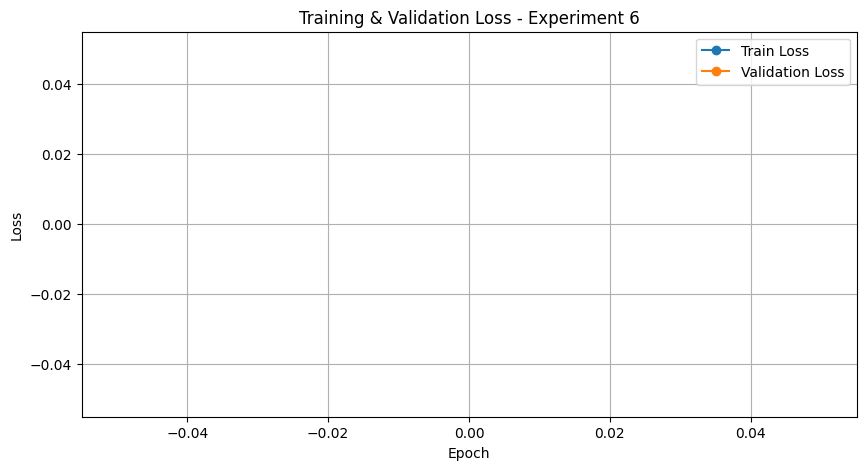

Подсчёт WER на валидационном датасете...
WER: 0.8571


In [57]:
experiment_id = 6
save_metrics_and_evaluate_whisper(trainer, experiment_id, model_whisper, processor, dataset_whisper, sample_size=2)

### Эксперимент 7: openai/whisper-small + LoRA (dropout=0.4) + Trainer (warmup_steps=500, earning_rate=3e-5) + аугментация

In [58]:
from datasets import load_from_disk
from torch.utils.data import DataLoader

dataset_whisper = load_from_disk("./sample_datasets/whisper")
print(dataset_whisper)

dataset_whisper.set_format(type="torch", columns=["input_features", "labels"])
print(type(dataset_whisper["train"][0]["input_features"]))
print(type(dataset_whisper["train"][0]["labels"]))

DatasetDict({
    train: Dataset({
        features: ['input_features', 'labels'],
        num_rows: 10
    })
    validation: Dataset({
        features: ['input_features', 'labels'],
        num_rows: 2
    })
})
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [59]:
from datasets import DatasetDict

augmented_train = load_from_disk("./sample_datasets/whisper_augmented")
print(augmented_train)

# Создаём новый датасет для валидации во время обучения
augmented_train = augmented_train.train_test_split(test_size=0.05, seed=42)

dataset_resplit = DatasetDict({
    "train": augmented_train["train"],
    "validation": augmented_train["test"]  # Новый датасет для тюнинга
})

Dataset({
    features: ['input_features', 'labels'],
    num_rows: 10
})


In [60]:
model_whisper, processor = load_whisper_with_lora(model_name="openai/whisper-small", r=16, alpha=32, dropout=0.4)

LoRA успешно применена к модели Whisper!
Количество тренируемых параметров: 247070976


In [61]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./models/whisper-finetuned-ru",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end = True,
    save_total_limit=2,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=2,
    eval_accumulation_steps=4,
    num_train_epochs=10,
    lr_scheduler_type="cosine_with_restarts",
    warmup_steps=500,
    learning_rate=3e-5,
    weight_decay=0.01,
    logging_dir="./outputs/logs",
    logging_steps=10,
    report_to="none",
    push_to_hub=False,
    bf16=False,
    fp16=True,
    optim="adamw_torch_fused",
    max_grad_norm=0.5,
    dataloader_pin_memory=True
)

data_collator = WhisperDataCollator(processor)

In [62]:
trainer=train_whisper(dataset_resplit, model_whisper, processor, data_collator, training_args)

Всего памяти GPU: 42.47 GB
Свободная память GPU: 5.06 GB
Используемая память GPU: 3.99 GB


<ipython-input-9-e62e31a29de2>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_features = [torch.tensor(f["input_features"], dtype=torch.float16) for f in features]
<ipython-input-9-e62e31a29de2>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = [torch.tensor(f["labels"], dtype=torch.int64) for f in features]


Epoch,Training Loss,Validation Loss
1,No log,1.987594
2,No log,1.987594
3,No log,1.987594
4,No log,1.987594


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:2758: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
<ipython-input-9-e62e31a29de2>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.c

Обучение завершено.


Обучение завершено. Метрики сохранены в ./outputs/whisper_training_losses_experiment_7.csv


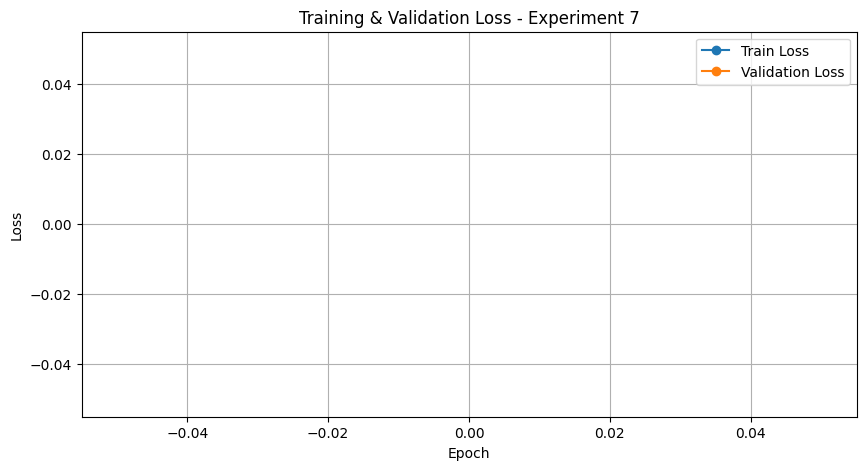

Подсчёт WER на валидационном датасете...
WER: 0.8571


In [63]:
experiment_id = 7
save_metrics_and_evaluate_whisper(trainer, experiment_id, model_whisper, processor, dataset_whisper, sample_size=2)

In [64]:
import torch
from transformers import WhisperProcessor

# Define paths
base_model_path = "./models/whisper-finetuned-ru"

# Save base model
model_whisper.save_pretrained(base_model_path)
processor.save_pretrained(base_model_path)

full_model_path = base_model_path+"/whisper_lora_full.pth"
torch.save(model_whisper.state_dict(), full_model_path)

lora_weights_path = base_model_path+"/whisper_lora_weights.pth"
lora_weights = {k: v for k, v in model_whisper.state_dict().items() if "lora" in k}
torch.save(lora_weights, lora_weights_path)

## Шаг 2: Обучение DeepSeek R1

Функция рассчёта метрик

In [65]:
from rouge_score import rouge_scorer
from bert_score import score
import json
import numpy as np
import torch
from tqdm import tqdm  # Для отображения прогресса

# Создаём объект ROUGE scorer (оцениваем только rougeL)
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

def batch_infer(batch_texts, model, tokenizer, batch_size=8):
    """
    Выполняет инференс модели для списка текстов пакетами (batch) для ускорения.

    Параметры:
    - batch_texts (list[str]): Список входных текстов.
    - model: Модель для инференса.
    - tokenizer: Токенизатор для обработки текста.
    - batch_size (int): Размер батча (по умолчанию 8).

    Возвращает:
    - list: Список предсказанных текстов.
    """
    results = []
    for i in range(0, len(batch_texts), batch_size):
        batch = batch_texts[i : i + batch_size]

        with torch.no_grad():  # Отключаем градиенты для ускорения инференса
            batch_outputs = [extract_meeting_summary(model, tokenizer, text) for text in batch]

        results.extend(batch_outputs)
    return results

def compute_rouge(prediction, reference):
    """
    Вычисляет метрику ROUGE-L между предсказанием и эталонным текстом.

    Параметры:
    - prediction (str): Предсказанный текст.
    - reference (str): Эталонный текст.

    Возвращает:
    - float: Значение f-measure для ROUGE-L.

    Описание:
    - Проверяет, что входные тексты не пустые.
    - Если хотя бы один текст пустой, возвращает 0.0.
    - Вычисляет ROUGE-L f-меру.
    """
    if not isinstance(prediction, str) or not isinstance(reference, str) or not prediction.strip() or not reference.strip():
        return 0.0  # Избегаем оценки пустых или некорректных текстов
    return scorer.score(prediction, reference)["rougeL"].fmeasure

def compute_bertscore(prediction, reference):
    """
    Вычисляет BERTScore между предсказанным и эталонным текстом.

    Параметры:
    - prediction (str): Предсказанный текст.
    - reference (str): Эталонный текст.

    Возвращает:
    - float: Среднее значение F1-меры BERTScore.

    Описание:
    - Проверяет, что входные тексты не пустые.
    - Если текст пустой или не строка, возвращает 0.0.
    - Вычисляет BERTScore, используя многозадачный языковой режим.
    """
    if not isinstance(prediction, str) or not isinstance(reference, str) or not prediction.strip() or not reference.strip():
        return 0.0
    try:
        P, R, F1 = score([prediction], [reference], lang="multilingual")
        return F1.mean().item()
    except Exception as e:
        print(f"Ошибка при вычислении BERTScore: {e}")
        return 0.0

def is_valid_json(text):
    """
    Проверяет, является ли строка корректным JSON.

    Параметры:
    - text (str): Входная строка.

    Возвращает:
    - float: 1.0, если текст — корректный JSON, иначе 0.0.
    """
    try:
        json.loads(text)
        return 1.0
    except:
        return 0.0

def compute_json_validity(prediction):
    """
    Проверяет корректность формата JSON-предсказания.

    Параметры:
    - prediction: Объект JSON или строка.

    Возвращает:
    - float: 1.0, если JSON корректен, иначе 0.0.

    Описание:
    - Преобразует объект в строку JSON.
    - Затем проверяет, можно ли его успешно декодировать обратно.
    """
    try:
        json_str = json.dumps(prediction, ensure_ascii=False)
        json.loads(json_str)  # Проверяем, можно ли распарсить обратно
        return 1.0
    except (TypeError, ValueError):
        return 0.0

def compute_metrics(prediction, reference):
    """
    Вычисляет несколько метрик для оценки качества предсказаний.

    Параметры:
    - prediction (str): Предсказанный текст.
    - reference (str): Эталонный текст.

    Возвращает:
    - tuple (float, float, float): Значения ROUGE-L, BERTScore и JSON Validity.

    Описание:
    - Вычисляет метрику ROUGE-L.
    - Вычисляет BERTScore (F1-меру).
    - Проверяет корректность формата JSON.
    """
    rouge_score = compute_rouge(prediction, reference)
    bert_score = compute_bertscore(prediction, reference)
    json_validity_score = compute_json_validity(prediction)

    return rouge_score, bert_score, json_validity_score

Функция проверки модели на датасете

In [73]:
import json
import re
import time
import ast
import torch
import numpy as np
from tqdm import tqdm
from pydantic import BaseModel, ValidationError

# Определяем структуру выходных данных с использованием Pydantic
class MeetingSummary(BaseModel):
    Summarization: str
    Topics: list[str]
    Actions: list[str]
    Problems: list[str]
    Decisions: list[str]

# Шаблон JSON-ответа
REFERENCE_JSON = {
    "Summarization": "Brief meeting summary...",
    "Topics": ["Topic 1", "Topic 2"],
    "Actions": ["Action 1", "Action 2"],
    "Problems": ["Problem 1", "Problem 2"],
    "Decisions": ["Decision 1", "Decision 2"]
}

# Фиксированный промпт без транскрипта
PROMPT_TEMPLATE = """
Analyze the following meeting transcript and extract the key points:
    1. **Summarization** – a brief summary of the meeting.
    2. **Topics** – a list of topics discussed.
    3. **Decisions** – key decisions made.
    4. **Problems** – challenges or issues identified.
    5. **Actions** – planned or taken actions.

    Return the output **STRICTLY in the following JSON format**:
    {{
      "Summarization": "Brief meeting summary...",
      "Topics": ["Topic 1", "Topic 2"],
      "Actions": ["Action 1", "Action 2"],
      "Problems": ["Problem 1", "Problem 2"],
      "Decisions": ["Decision 1", "Decision 2"]
    }}

    Meeting transcript (in Russian):
    {transcript}

    **Return only a valid JSON response in Russian language.**
    **Do not include explanations, introductions, or extra text.**
    **If a category is missing, return an empty array [].**
"""

def clean_json_fields(data):
    """
    Очищает JSON, исправляя списки, если они закодированы как строки.
    """
    for key in ["Topics", "Actions", "Problems", "Decisions"]:
        if isinstance(data.get(key), list):
            cleaned_list = []
            for item in data[key]:
                if isinstance(item, str) and item.startswith("["):
                    try:
                        cleaned_list.extend(ast.literal_eval(item))
                    except (SyntaxError, ValueError):
                        cleaned_list.append(item)
                else:
                    cleaned_list.append(item)
            data[key] = cleaned_list
    return data

def extract_valid_json(text):
    """
    Извлекает первый валидный JSON из текста.
    """
    text = text.strip()
    text = re.sub(r"^### Response:\s*", "", text)
    text = re.sub(r"^Response:\s*", "", text)
    json_matches = re.findall(r"\{[\s\S]*?\}", text)

    for json_text in json_matches:
        try:
            extracted_json = json.loads(json_text)
        except json.JSONDecodeError:
            try:
                extracted_json = ast.literal_eval(json_text)
            except (ValueError, SyntaxError):
                continue
        extracted_json = clean_json_fields(extracted_json)
        if extracted_json and extracted_json != REFERENCE_JSON:
            return extracted_json

    return None

def split_transcript(tokenizer, transcript, max_tokens=3000, overlap=300):
    """
    Разбивает длинные транскрипты на части, чтобы избежать превышения длины контекста модели.
    """
    tokens = tokenizer.tokenize(transcript)
    chunks = []
    start = 0
    while start < len(tokens):
        end = min(start + max_tokens, len(tokens))
        chunk = tokenizer.convert_tokens_to_string(tokens[start:end])
        chunks.append(chunk)
        start += max_tokens - overlap
    return chunks

def generate_response(model, tokenizer, chunk: str) -> str:
    """
    Генерирует предсказание модели для одного фрагмента транскрипта.
    """
    prompt = PROMPT_TEMPLATE.format(transcript=chunk)
    inputs = tokenizer([prompt], return_tensors="pt", truncation=True, max_length=4096).to("cuda")
    with torch.inference_mode():
        output_ids = model.generate(**inputs, max_new_tokens=500, do_sample=False)
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

def summarize_chunk(model, tokenizer, chunk):
    """
    Обрабатывает один фрагмент транскрипта, запуская генерацию и парсинг JSON.
    """
    response = generate_response(model, tokenizer, chunk)
    print("Response:\n", response)
    json_data = extract_valid_json(response)
    print("JSON:\n", json_data)
    return json_data

def merge_chunks(chunk_summaries):
    """
    Объединяет JSON-ответы из нескольких чанков в один итоговый результат.

    Описание:
    - `Summarization` объединяется в один текст.
    - `Topics`, `Actions`, `Problems`, `Decisions` объединяются в множества (set) для удаления дубликатов.
    """
    merged = {
        "Summarization": " ".join([chunk.get("Summarization", "") for chunk in chunk_summaries]).strip(),
        "Topics": list(set(sum([chunk.get("Topics", []) for chunk in chunk_summaries], []))),
        "Actions": list(set(sum([chunk.get("Actions", []) for chunk in chunk_summaries], []))),
        "Problems": list(set(sum([chunk.get("Problems", []) for chunk in chunk_summaries], []))),
        "Decisions": list(set(sum([chunk.get("Decisions", []) for chunk in chunk_summaries], []))),
    }
    return merged

def extract_meeting_summary(model, tokenizer, input_text: str, retry_attempts=3):
    """
    Обрабатывает полный транскрипт, разбивая его на части и собирая итоговое резюме.
    """
    attempts = 0
    while attempts < retry_attempts:
        chunks = split_transcript(tokenizer, input_text)
        chunk_summaries = []

        for chunk in chunks:
            summary = summarize_chunk(model, tokenizer, chunk)

            if summary is not None:
                chunk_summaries.append(summary)

        if chunk_summaries:
            return merge_chunks(chunk_summaries)

        print(f"Попытка {attempts + 1}: все чанки пустые. Повторная попытка...")
        attempts += 1

    print("Ошибка: не удалось получить данные после всех попыток!")
    return {}  # Возвращаем пустой JSON

def check_model(model, tokenizer, dataset, num_samples=2):
    """
    Оценивает модель на подмножестве валидационного датасета.
    """
    validation_set = dataset["validation"]
    if num_samples:
        validation_set = validation_set.select(range(min(num_samples, len(validation_set))))

    rouge_scores, bert_scores, json_validity_scores = [], [], []

    for example in tqdm(validation_set, desc=f"Evaluating on {len(validation_set)} Samples"):
        sample_text = example["input_text"]
        prediction = extract_meeting_summary(model, tokenizer, sample_text)
        reference = example["output_text"]

        prediction_text = json.dumps(prediction, ensure_ascii=False, indent=None)
        reference_text = json.dumps(reference, ensure_ascii=False, indent=None) if isinstance(reference, dict) else reference

        rouge_scores.append(compute_rouge(prediction_text, reference_text))
        bert_scores.append(compute_bertscore(prediction_text, reference_text))
        json_validity_scores.append(compute_json_validity(prediction_text))

    final_metrics = {
        "rougeL": np.mean(rouge_scores),
        "bert_f1": np.mean(bert_scores)
    }
    print("\nФинальные метрики:", final_metrics)
    return final_metrics

Функция анализа и вывода метрик

In [74]:
import os
import gc
import pandas as pd
import matplotlib.pyplot as plt

def save_metrics_and_evaluate_r1(trainer, experiment_id, model_r1, tokenizer, dataset_r1, num_samples=1):
    """
    Сохраняет метрики обучения, строит график и вычисляет метрики качества модели.

    Параметры:
    - trainer: Экземпляр тренера модели.
    - experiment_id (int): Номер эксперимента для сохранения файлов.
    - model_r1: Модель для оценки.
    - tokenizer: Токенизатор модели.
    - dataset_r1: Валидационный датасет для вычисления метрик.

    Возвращает:
    - None (Сохраняет CSV-файл с метриками и строит график).
    """
    # Получаем параметры тренировки
    eval_strategy = trainer.args.eval_strategy  # 'epoch' или 'steps'
    eval_steps = trainer.args.eval_steps  # Количество шагов между валидациями
    num_epochs = int(trainer.args.num_train_epochs)  # Общее количество эпох

    train_losses = []
    val_losses = []
    valid_steps = []

    if eval_strategy == "steps":
        # Словари для хранения значений потерь
        step_train_loss = {}  # Сопоставление шаг -> train_loss
        step_eval_loss = {}   # Сопоставление шаг -> eval_loss

        # Обрабатываем логи тренировки
        for log in trainer.state.log_history:
            step = log.get("step", None)
            if step is None:
                continue

            if "loss" in log:
                step_train_loss[step] = log["loss"]  # Сохраняем train loss на этом шаге
            if "eval_loss" in log:
                step_eval_loss[step] = log["eval_loss"]  # Сохраняем eval loss на этом шаге

        # Оставляем только шаги, для которых есть оба значения
        valid_steps = sorted(set(step_train_loss.keys()) & set(step_eval_loss.keys()))

        # Извлекаем значения для допустимых шагов
        train_losses = [step_train_loss[step] for step in valid_steps]
        val_losses = [step_eval_loss[step] for step in valid_steps]

    elif eval_strategy == "epoch":
        # Выбираем логи с доступными значениями eval_loss
        eval_logs = [log for log in trainer.state.log_history if "eval_loss" in log]

        # Обрабатываем логи и сопоставляем train_loss с eval_loss
        for eval_log in eval_logs:
            step_or_epoch = eval_log["step"] if eval_strategy == "steps" else int(eval_log["epoch"])
            val_loss = eval_log["eval_loss"]

            # Ищем последнее значение train_loss перед этим шагом/эпохой
            train_loss = None
            for train_log in reversed(trainer.state.log_history):
                if "loss" in train_log and train_log["step"] <= eval_log["step"]:
                    train_loss = train_log["loss"]
                    break

            if train_loss is not None:
                valid_steps.append(step_or_epoch)
                train_losses.append(train_loss)
                val_losses.append(val_loss)

    # Создаем DataFrame с метриками
    metrics_df = pd.DataFrame({
        "step_or_epoch": valid_steps,
        "train_loss": train_losses,
        "val_loss": val_losses
    })

    # Определяем путь для сохранения
    save_dir = "./outputs"
    os.makedirs(save_dir, exist_ok=True)  # Создаем директорию, если она не существует
    csv_path = f"{save_dir}/r1_training_losses_experiment_{experiment_id}.csv"

    # Сохраняем метрики в CSV
    metrics_df.to_csv(csv_path, index=False)
    print(f"Обучение успешно завершено. Метрики сохранены в {csv_path}")

    # Построение графика потерь обучения и валидации
    plt.figure(figsize=(10, 5))
    plt.plot(metrics_df["train_loss"], label="Train Loss", marker="o")
    plt.plot(metrics_df["val_loss"], label="Validation Loss", marker="o")
    plt.xlabel("Шаги")
    plt.ylabel("Loss")
    plt.title(f"График потерь - Эксперимент {experiment_id}")
    plt.legend()
    plt.grid()
    plt.show()

    # Вычисление метрик качества модели на валидационном наборе
    print("Вычисление метрик Rouge_L, BERTScore и JSON validity...")
    final_metrics = check_model(model_r1, tokenizer, dataset_r1, num_samples=num_samples)

    del metrics_df
    del final_metrics
    gc.collect()

Функция очистки памяти

In [75]:
import gc
import torch

def clean_memory(variables_to_delete):
    """
    Очищает память, удаляя указанные переменные и освобождая GPU.

    Параметры:
    - variables_to_delete (list): Список имен переменных, которые необходимо удалить.

    Возвращает:
    - None

    Описание:
    - Проверяет, существуют ли переданные переменные в глобальной области видимости.
    - Удаляет найденные переменные.
    - Запускает сборщик мусора для освобождения оперативной памяти.
    - Очищает кеш видеопамяти CUDA.
    """

    # Проверяем, существуют ли переменные в глобальной области и удаляем их
    for var in variables_to_delete:
        if var in globals():
            del globals()[var]
            print(f"Удалено: {var}")

    # Запускаем сборщик мусора для очистки оперативной памяти
    gc.collect()

    # Очищаем кеш видеопамяти CUDA
    torch.cuda.empty_cache()

    print("Очистка памяти успешно выполнена!")

### Оценка модели до обучения

In [70]:
from datasets import load_from_disk
dataset_r1 = load_from_disk("./sample_datasets/processed_dataset_r1")
print(dataset_r1)

DatasetDict({
    train: Dataset({
        features: ['input_text', 'output_text', 'text'],
        num_rows: 9
    })
    validation: Dataset({
        features: ['input_text', 'output_text', 'text'],
        num_rows: 1
    })
})


In [71]:
from unsloth import FastLanguageModel
import torch

max_seq_length=16_384
max_new_tokens=500

model_r1, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/DeepSeek-R1-Distill-Qwen-1.5B-unsloth-bnb-4bit",
    max_seq_length=max_seq_length,
    dtype=torch.bfloat16,  # Используем BF16, если у вас A100
    load_in_4bit=True,
    device_map="auto",
    max_memory={0: "38GiB", "cpu": "10GiB"},
    attn_implementation="flash_attention_2",  # Включаем FA2
    trust_remote_code=True
)

<ipython-input-71-14211a508ee2>:1: UserWarning: WARNING: Unsloth should be imported before transformers, peft to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel


Unsloth: Patching Xformers to fix some performance issues.
🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
Unsloth: WARNING `trust_remote_code` is True.
Are you certain you want to do remote code execution?
==((====))==  Unsloth 2025.3.5: Fast Qwen2 patching. Transformers: 4.48.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.27.post2. FA2 = True]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/1.81G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/236 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/6.78k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

In [76]:
final_metrics = check_model(model_r1, tokenizer, dataset_r1, num_samples=1)

Evaluating on 1 Samples:   0%|          | 0/1 [00:00<?, ?it/s]

Response:
 
Analyze the following meeting transcript and extract the key points:
    1. **Summarization** – a brief summary of the meeting.
    2. **Topics** – a list of topics discussed.
    3. **Decisions** – key decisions made.
    4. **Problems** – challenges or issues identified.
    5. **Actions** – planned or taken actions.

    Return the output **STRICTLY in the following JSON format**:
    {
      "Summarization": "Brief meeting summary...",
      "Topics": ["Topic 1", "Topic 2"],
      "Actions": ["Action 1", "Action 2"],
      "Problems": ["Problem 1", "Problem 2"],
      "Decisions": ["Decision 1", "Decision 2"]
    }

    Meeting transcript (in Russian):
    B: Теперь все в порядке? B: . B: Извините? B: все готовы начать встречу? У нас есть полчаса, чтобы обсудить функциональный дизайн. Все готовы начать? . Надеюсь, вы все работали, и я поместил протокол последней встречи в папку проекта. Думаю, чтобы подвести итоги того, что мы делали в прошлый раз. немного узнали друг д

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Evaluating on 1 Samples: 100%|██████████| 1/1 [03:59<00:00, 239.09s/it]


Финальные метрики: {'rougeL': 0.0, 'bert_f1': 0.40452080965042114}


In [77]:
clean_memory(["dataset_r1", "model_r1", "tokenizer"])

Удалено: dataset_r1
Удалено: model_r1
Удалено: tokenizer
Очистка памяти успешно выполнена!


### Эксперимент 1: DeepSeek-R1-Distill-Qwen-1.5B + Unsloth + LoRA (r=4, alpha=16, dropout=0)

In [78]:
from datasets import load_from_disk
dataset_r1 = load_from_disk("./sample_datasets/processed_dataset_r1")
print(dataset_r1)

DatasetDict({
    train: Dataset({
        features: ['input_text', 'output_text', 'text'],
        num_rows: 9
    })
    validation: Dataset({
        features: ['input_text', 'output_text', 'text'],
        num_rows: 1
    })
})


In [79]:
from unsloth import FastLanguageModel
import torch

max_seq_length=16_384
max_new_tokens=500

model_r1, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/DeepSeek-R1-Distill-Qwen-1.5B-unsloth-bnb-4bit",
    max_seq_length=max_seq_length,
    dtype=torch.bfloat16,  # Используем BF16, если у вас A100
    load_in_4bit=True,
    device_map="auto",
    max_memory={0: "38GiB", "cpu": "10GiB"},
    attn_implementation="flash_attention_2",  # Включаем FA2
    trust_remote_code=True
)

Unsloth: WARNING `trust_remote_code` is True.
Are you certain you want to do remote code execution?
==((====))==  Unsloth 2025.3.5: Fast Qwen2 patching. Transformers: 4.48.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.27.post2. FA2 = True]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [80]:
model_r1 = FastLanguageModel.get_peft_model(
    model_r1,
    r=4,
    lora_alpha=16,
    lora_dropout=0,
    target_modules=["q_proj", "k_proj", "v_proj", "up_proj", "down_proj", "o_proj", "gate_proj"],
    use_rslora=True,
    use_gradient_checkpointing="unsloth"
)

Unsloth 2025.3.5 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


In [81]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model_r1,
    tokenizer = tokenizer,
    train_dataset = dataset_r1["train"],
    eval_dataset = dataset_r1["validation"],
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 1,
    packing = False,
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        per_device_eval_batch_size = 1,
        warmup_steps = 5,
        num_train_epochs = 1,
        eval_strategy="steps",
        save_strategy="steps",
        eval_steps=100,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        seed = 3407,
        gradient_checkpointing=True,
        output_dir = "./models/unsloth_deepseek_r1_finetuned_16K",
        report_to = "none",
    ),
)

Tokenizing to ["text"]:   0%|          | 0/9 [00:00<?, ? examples/s]

Tokenizing to ["text"]:   0%|          | 0/1 [00:00<?, ? examples/s]

In [82]:
train_metrics=trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 9 | Num Epochs = 1 | Total steps = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 4,616,192/1,192,470,016 (0.39% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss


Обучение успешно завершено. Метрики сохранены в ./outputs/r1_training_losses_experiment_1.csv


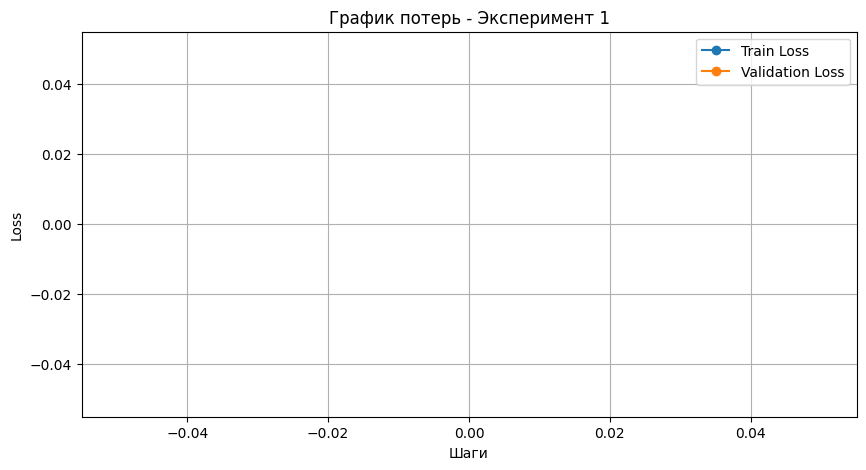

Вычисление метрик Rouge_L, BERTScore и JSON validity...


Evaluating on 1 Samples:   0%|          | 0/1 [00:00<?, ?it/s]

Response:
 
Analyze the following meeting transcript and extract the key points:
    1. **Summarization** – a brief summary of the meeting.
    2. **Topics** – a list of topics discussed.
    3. **Decisions** – key decisions made.
    4. **Problems** – challenges or issues identified.
    5. **Actions** – planned or taken actions.

    Return the output **STRICTLY in the following JSON format**:
    {
      "Summarization": "Brief meeting summary...",
      "Topics": ["Topic 1", "Topic 2"],
      "Actions": ["Action 1", "Action 2"],
      "Problems": ["Problem 1", "Problem 2"],
      "Decisions": ["Decision 1", "Decision 2"]
    }

    Meeting transcript (in Russian):
    B: Теперь все в порядке? B: . B: Извините? B: все готовы начать встречу? У нас есть полчаса, чтобы обсудить функциональный дизайн. Все готовы начать? . Надеюсь, вы все работали, и я поместил протокол последней встречи в папку проекта. Думаю, чтобы подвести итоги того, что мы делали в прошлый раз. немного узнали друг д

Evaluating on 1 Samples: 100%|██████████| 1/1 [05:25<00:00, 325.04s/it]



Финальные метрики: {'rougeL': 0.0, 'bert_f1': 0.40452080965042114}


In [83]:
experiment_id = 1
save_metrics_and_evaluate_r1(trainer, experiment_id, model_r1, tokenizer, dataset_r1, num_samples=1)

In [84]:
clean_memory(["dataset_r1", "model_r1", "tokenizer", "trainer", "training_args"])

Удалено: dataset_r1
Удалено: model_r1
Удалено: tokenizer
Удалено: trainer
Удалено: training_args
Очистка памяти успешно выполнена!


### Эксперимент 2: DeepSeek-R1-Distill-Qwen-1.5B + Unsloth + LoRA (r=8, alpha=16, dropout=0.1) + Trainer(learning_rate = 1e-4,  lr_scheduler_type = "linear", optim = "adamw_8bit", weight_decay = 0.01)

In [85]:
from datasets import load_from_disk
dataset_r1 = load_from_disk("./sample_datasets/processed_dataset_r1")
print(dataset_r1)

DatasetDict({
    train: Dataset({
        features: ['input_text', 'output_text', 'text'],
        num_rows: 9
    })
    validation: Dataset({
        features: ['input_text', 'output_text', 'text'],
        num_rows: 1
    })
})


In [86]:
from unsloth import FastLanguageModel
import torch

max_seq_length=16_384
max_new_tokens=500

model_r1, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/DeepSeek-R1-Distill-Qwen-1.5B-unsloth-bnb-4bit",
    max_seq_length=max_seq_length,
    dtype=torch.bfloat16,  # Используем BF16, если у вас A100
    load_in_4bit=True,
    device_map="auto",
    max_memory={0: "38GiB", "cpu": "10GiB"},
    attn_implementation="flash_attention_2",  # Включаем FA2
    trust_remote_code=True
)

Unsloth: WARNING `trust_remote_code` is True.
Are you certain you want to do remote code execution?
==((====))==  Unsloth 2025.3.5: Fast Qwen2 patching. Transformers: 4.48.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.27.post2. FA2 = True]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [87]:
model_r1 = FastLanguageModel.get_peft_model(
    model_r1,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["q_proj", "k_proj", "v_proj", "up_proj", "down_proj", "o_proj", "gate_proj"],
    use_rslora=True,
    use_gradient_checkpointing="unsloth"
)

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.1.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2025.3.5 patched 28 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


In [88]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model_r1,
    tokenizer = tokenizer,
    train_dataset = dataset_r1["train"],
    eval_dataset = dataset_r1["validation"],
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 1,
    packing = False,
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        per_device_eval_batch_size = 1,
        warmup_steps = 5,
        num_train_epochs = 1,
        eval_strategy="steps",
        save_strategy="steps",
        eval_steps=100,
        learning_rate = 1e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        gradient_checkpointing=True,
        output_dir = "./models/unsloth_deepseek_r1_finetuned_16K",
        report_to = "none",
    ),
)

Tokenizing to ["text"]:   0%|          | 0/1 [00:00<?, ? examples/s]

In [89]:
train_metrics=trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 9 | Num Epochs = 1 | Total steps = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 9,232,384/1,197,086,208 (0.77% trained)


Step,Training Loss,Validation Loss


Обучение успешно завершено. Метрики сохранены в ./outputs/r1_training_losses_experiment_2.csv


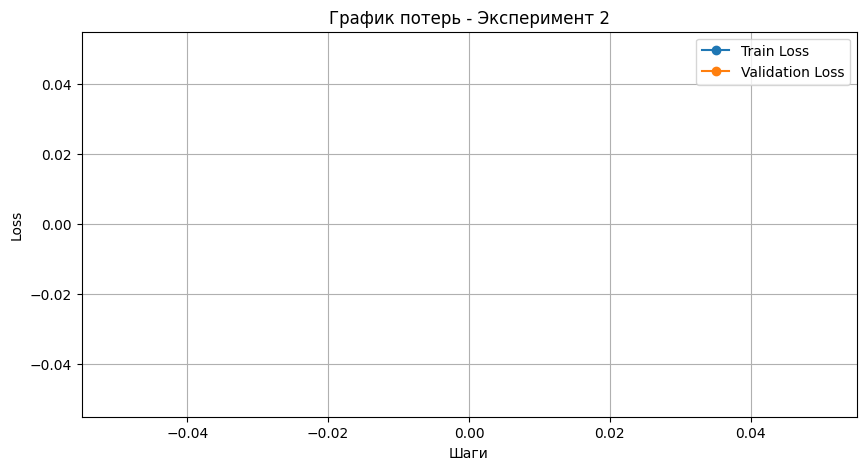

Вычисление метрик Rouge_L, BERTScore и JSON validity...


Evaluating on 1 Samples:   0%|          | 0/1 [00:00<?, ?it/s]

Response:
 
Analyze the following meeting transcript and extract the key points:
    1. **Summarization** – a brief summary of the meeting.
    2. **Topics** – a list of topics discussed.
    3. **Decisions** – key decisions made.
    4. **Problems** – challenges or issues identified.
    5. **Actions** – planned or taken actions.

    Return the output **STRICTLY in the following JSON format**:
    {
      "Summarization": "Brief meeting summary...",
      "Topics": ["Topic 1", "Topic 2"],
      "Actions": ["Action 1", "Action 2"],
      "Problems": ["Problem 1", "Problem 2"],
      "Decisions": ["Decision 1", "Decision 2"]
    }

    Meeting transcript (in Russian):
    B: Теперь все в порядке? B: . B: Извините? B: все готовы начать встречу? У нас есть полчаса, чтобы обсудить функциональный дизайн. Все готовы начать? . Надеюсь, вы все работали, и я поместил протокол последней встречи в папку проекта. Думаю, чтобы подвести итоги того, что мы делали в прошлый раз. немного узнали друг д

Evaluating on 1 Samples: 100%|██████████| 1/1 [05:20<00:00, 320.31s/it]



Финальные метрики: {'rougeL': 0.0, 'bert_f1': 0.40452080965042114}


In [90]:
experiment_id = 2
save_metrics_and_evaluate_r1(trainer, experiment_id, model_r1, tokenizer, dataset_r1, num_samples=1)

In [91]:
clean_memory(["dataset_r1", "model_r1", "tokenizer", "trainer", "training_args"])

Удалено: dataset_r1
Удалено: model_r1
Удалено: tokenizer
Удалено: trainer
Очистка памяти успешно выполнена!


### Эксперимент 3: DeepSeek-R1-Distill-Qwen-1.5B + Unsloth + LoRA (r=16, alpha=16, dropout=0.2) + Trainer (learning_rate = 2e-4)

In [92]:
from datasets import load_from_disk
dataset_r1 = load_from_disk("./sample_datasets/processed_dataset_r1")
print(dataset_r1)

DatasetDict({
    train: Dataset({
        features: ['input_text', 'output_text', 'text'],
        num_rows: 9
    })
    validation: Dataset({
        features: ['input_text', 'output_text', 'text'],
        num_rows: 1
    })
})


In [93]:
from unsloth import FastLanguageModel
import torch

max_seq_length=16_384
max_new_tokens=500

model_r1, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/DeepSeek-R1-Distill-Qwen-1.5B-unsloth-bnb-4bit",
    max_seq_length=max_seq_length,
    dtype=torch.bfloat16,  # Используем BF16, если у вас A100
    load_in_4bit=True,
    device_map="auto",
    max_memory={0: "38GiB", "cpu": "10GiB"},
    attn_implementation="flash_attention_2",  # Включаем FA2
    trust_remote_code=True
)

Unsloth: WARNING `trust_remote_code` is True.
Are you certain you want to do remote code execution?
==((====))==  Unsloth 2025.3.5: Fast Qwen2 patching. Transformers: 4.48.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.27.post2. FA2 = True]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [94]:
model_r1 = FastLanguageModel.get_peft_model(
    model_r1,
    r=16,
    lora_alpha=16,
    lora_dropout=0.2,
    target_modules=["q_proj", "k_proj", "v_proj", "up_proj", "down_proj", "o_proj", "gate_proj"],
    use_rslora=True,
    use_gradient_checkpointing="unsloth"
)

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.2.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.


In [95]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model_r1,
    tokenizer = tokenizer,
    train_dataset = dataset_r1["train"],
    eval_dataset = dataset_r1["validation"],
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 1,
    packing = False,
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        per_device_eval_batch_size = 1,
        warmup_steps = 5,
        num_train_epochs = 1,
        eval_strategy="steps",
        save_strategy="steps",
        eval_steps=100,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        gradient_checkpointing=True,
        output_dir = "./models/unsloth_deepseek_r1_finetuned_16K",
        report_to = "none",
    ),
)

In [96]:
train_metrics=trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 9 | Num Epochs = 1 | Total steps = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 18,464,768/1,206,318,592 (1.53% trained)


Step,Training Loss,Validation Loss


Обучение успешно завершено. Метрики сохранены в ./outputs/r1_training_losses_experiment_3.csv


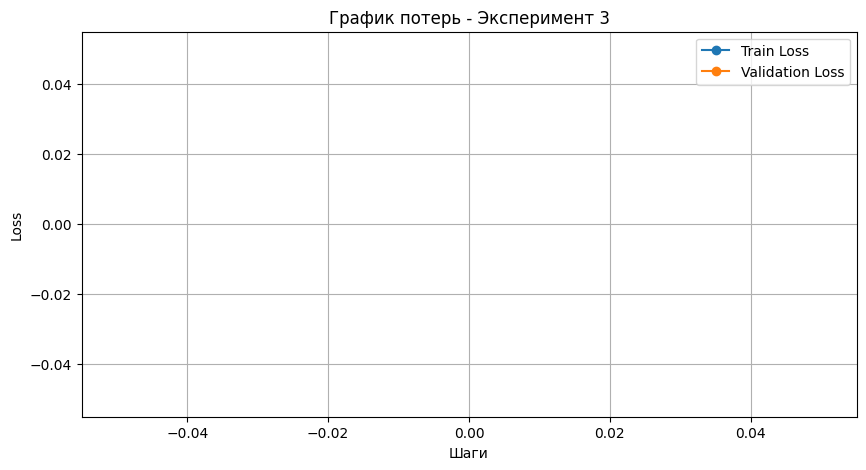

Вычисление метрик Rouge_L, BERTScore и JSON validity...


Evaluating on 1 Samples:   0%|          | 0/1 [00:00<?, ?it/s]

Response:
 
Analyze the following meeting transcript and extract the key points:
    1. **Summarization** – a brief summary of the meeting.
    2. **Topics** – a list of topics discussed.
    3. **Decisions** – key decisions made.
    4. **Problems** – challenges or issues identified.
    5. **Actions** – planned or taken actions.

    Return the output **STRICTLY in the following JSON format**:
    {
      "Summarization": "Brief meeting summary...",
      "Topics": ["Topic 1", "Topic 2"],
      "Actions": ["Action 1", "Action 2"],
      "Problems": ["Problem 1", "Problem 2"],
      "Decisions": ["Decision 1", "Decision 2"]
    }

    Meeting transcript (in Russian):
    B: Теперь все в порядке? B: . B: Извините? B: все готовы начать встречу? У нас есть полчаса, чтобы обсудить функциональный дизайн. Все готовы начать? . Надеюсь, вы все работали, и я поместил протокол последней встречи в папку проекта. Думаю, чтобы подвести итоги того, что мы делали в прошлый раз. немного узнали друг д

Evaluating on 1 Samples: 100%|██████████| 1/1 [05:21<00:00, 321.50s/it]


Финальные метрики: {'rougeL': 0.0, 'bert_f1': 0.40452080965042114}


In [97]:
experiment_id = 3
save_metrics_and_evaluate_r1(trainer, experiment_id, model_r1, tokenizer, dataset_r1, num_samples=1)

In [98]:
clean_memory(["dataset_r1", "model_r1", "tokenizer", "trainer", "training_args"])

Удалено: dataset_r1
Удалено: model_r1
Удалено: tokenizer
Удалено: trainer
Очистка памяти успешно выполнена!


### Эксперимент 4: DeepSeek-R1-Distill-Qwen-1.5B + Unsloth + LoRA (r=8, alpha=16, dropout=0.1) + Trainer (learning_rate = 1e-4) + увеличение эпох до 2

In [99]:
from datasets import load_from_disk
dataset_r1 = load_from_disk("./sample_datasets/processed_dataset_r1")
print(dataset_r1)

DatasetDict({
    train: Dataset({
        features: ['input_text', 'output_text', 'text'],
        num_rows: 9
    })
    validation: Dataset({
        features: ['input_text', 'output_text', 'text'],
        num_rows: 1
    })
})


In [100]:
from unsloth import FastLanguageModel
import torch

max_seq_length=16_384
max_new_tokens=500

model_r1, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/DeepSeek-R1-Distill-Qwen-1.5B-unsloth-bnb-4bit",
    max_seq_length=max_seq_length,
    dtype=torch.bfloat16,  # Используем BF16, если у вас A100
    load_in_4bit=True,
    device_map="auto",
    max_memory={0: "38GiB", "cpu": "10GiB"},
    attn_implementation="flash_attention_2",  # Включаем FA2
    trust_remote_code=True
)

Unsloth: WARNING `trust_remote_code` is True.
Are you certain you want to do remote code execution?
==((====))==  Unsloth 2025.3.5: Fast Qwen2 patching. Transformers: 4.48.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.27.post2. FA2 = True]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [101]:
model_r1 = FastLanguageModel.get_peft_model(
    model_r1,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["q_proj", "k_proj", "v_proj", "up_proj", "down_proj", "o_proj", "gate_proj"],
    use_rslora=True,
    use_gradient_checkpointing="unsloth"
)

In [102]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model_r1,
    tokenizer = tokenizer,
    train_dataset = dataset_r1["train"],
    eval_dataset = dataset_r1["validation"],
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 1,
    packing = False,
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 1,
        per_device_eval_batch_size = 1,
        warmup_steps = 10,
        num_train_epochs = 2,
        eval_strategy="steps",
        save_strategy="steps",
        save_total_limit=3,
        eval_steps=500,
        learning_rate = 1e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        gradient_checkpointing=True,
        output_dir = "./models/unsloth_deepseek_r1_finetuned_16K",
        report_to = "none",
    ),
)

In [103]:
train_metrics=trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 9 | Num Epochs = 2 | Total steps = 10
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 1 x 1) = 2
 "-____-"     Trainable parameters = 9,232,384/1,197,086,208 (0.77% trained)


Step,Training Loss,Validation Loss


Обучение успешно завершено. Метрики сохранены в ./outputs/r1_training_losses_experiment_4.csv


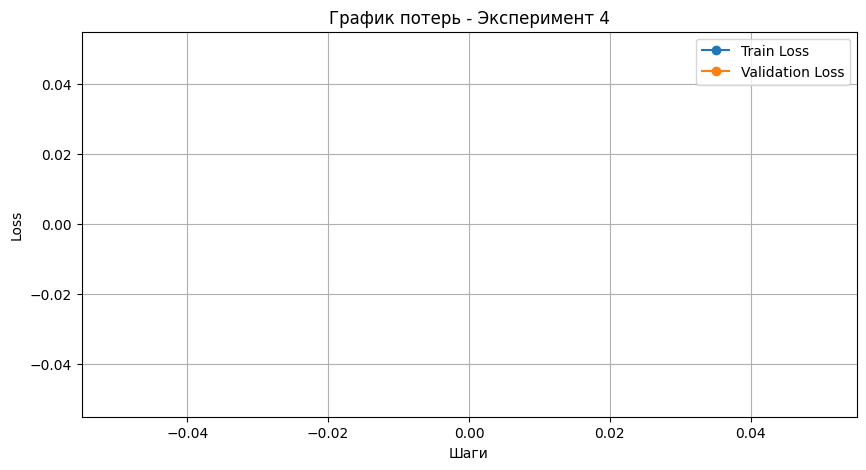

Вычисление метрик Rouge_L, BERTScore и JSON validity...


Evaluating on 1 Samples:   0%|          | 0/1 [00:00<?, ?it/s]

Response:
 
Analyze the following meeting transcript and extract the key points:
    1. **Summarization** – a brief summary of the meeting.
    2. **Topics** – a list of topics discussed.
    3. **Decisions** – key decisions made.
    4. **Problems** – challenges or issues identified.
    5. **Actions** – planned or taken actions.

    Return the output **STRICTLY in the following JSON format**:
    {
      "Summarization": "Brief meeting summary...",
      "Topics": ["Topic 1", "Topic 2"],
      "Actions": ["Action 1", "Action 2"],
      "Problems": ["Problem 1", "Problem 2"],
      "Decisions": ["Decision 1", "Decision 2"]
    }

    Meeting transcript (in Russian):
    B: Теперь все в порядке? B: . B: Извините? B: все готовы начать встречу? У нас есть полчаса, чтобы обсудить функциональный дизайн. Все готовы начать? . Надеюсь, вы все работали, и я поместил протокол последней встречи в папку проекта. Думаю, чтобы подвести итоги того, что мы делали в прошлый раз. немного узнали друг д

Evaluating on 1 Samples: 100%|██████████| 1/1 [05:22<00:00, 322.08s/it]


Финальные метрики: {'rougeL': 0.0, 'bert_f1': 0.40452080965042114}


In [104]:
experiment_id = 4
save_metrics_and_evaluate_r1(trainer, experiment_id, model_r1, tokenizer, dataset_r1, num_samples=1)

In [105]:
clean_memory(["dataset_r1", "model_r1", "tokenizer", "trainer", "training_args"])

Удалено: dataset_r1
Удалено: model_r1
Удалено: tokenizer
Удалено: trainer
Очистка памяти успешно выполнена!


### Эксперимент 5: DeepSeek-R1-Distill-Llama-8B + Unsloth + RoPe Scaling + LoRA (r=16, alpha=16, dropout=0.4) + Trainer (learning_rate = 1e-4, lr_scheduler_type = "linear", optim = "adamw_8bit", weight_decay = 0.01)

In [106]:
from datasets import load_from_disk
dataset_r1 = load_from_disk("./sample_datasets/processed_dataset_r1")
print(dataset_r1)

DatasetDict({
    train: Dataset({
        features: ['input_text', 'output_text', 'text'],
        num_rows: 9
    })
    validation: Dataset({
        features: ['input_text', 'output_text', 'text'],
        num_rows: 1
    })
})


In [107]:
import torch
from unsloth import FastLanguageModel

model_name = "unsloth/DeepSeek-R1-Distill-Llama-8B-unsloth-bnb-4bit"
max_seq_length=16_384
max_new_tokens=500

# Load model for 16K tokens
model_r1, tokenizer = FastLanguageModel.from_pretrained(
    model_name=model_name,
    max_seq_length=max_seq_length,
    dtype=None,
    load_in_4bit=True,
    rope_scaling={"type": "linear", "factor": 4},
    attn_implementation="flash_attention_2"
)

==((====))==  Unsloth 2025.3.5: Fast Llama patching. Transformers: 4.48.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.27.post2. FA2 = True]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.96G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/236 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/53.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [108]:
model_r1 = FastLanguageModel.get_peft_model(
    model_r1,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0.4,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

print("LoRA применен для эффективного fine-tuning!")

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.4.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2025.3.5 patched 32 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


LoRA применен для эффективного fine-tuning!


In [109]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model_r1,
    tokenizer = tokenizer,
    train_dataset = dataset_r1["train"],
    eval_dataset = dataset_r1["validation"],
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 1,
    packing = False,
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 1,
        per_device_eval_batch_size = 1,
        warmup_steps = 5,
        num_train_epochs = 1,
        eval_strategy="steps",
        save_strategy="steps",
        save_total_limit=3,
        eval_steps=500,
        learning_rate = 1e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        gradient_checkpointing=True,
        output_dir = "./models/unsloth_deepseek_r1_finetuned_16K",
        report_to = "none",
    ),
)

Tokenizing to ["text"]:   0%|          | 0/9 [00:00<?, ? examples/s]

Tokenizing to ["text"]:   0%|          | 0/1 [00:00<?, ? examples/s]

In [110]:
train_metrics=trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 9 | Num Epochs = 1 | Total steps = 5
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 1 x 1) = 2
 "-____-"     Trainable parameters = 41,943,040/4,670,623,744 (0.90% trained)


Step,Training Loss,Validation Loss


Обучение успешно завершено. Метрики сохранены в ./outputs/r1_training_losses_experiment_5.csv


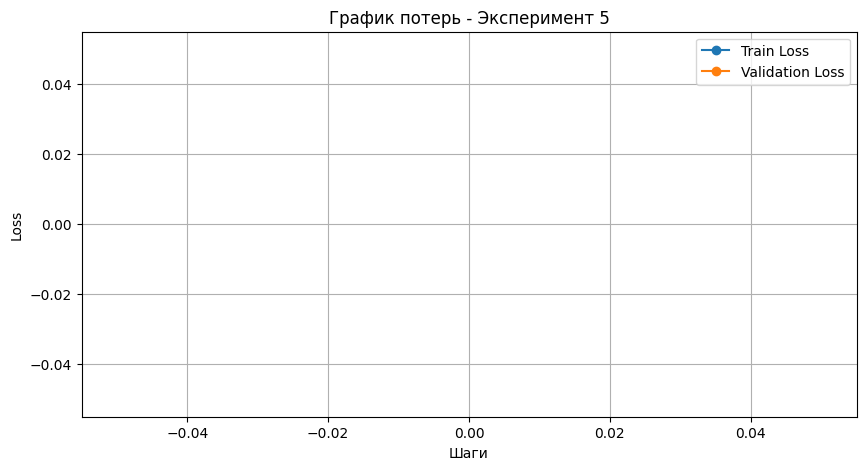

Вычисление метрик Rouge_L, BERTScore и JSON validity...


Evaluating on 1 Samples:   0%|          | 0/1 [00:00<?, ?it/s]

Response:
 
Analyze the following meeting transcript and extract the key points:
    1. **Summarization** – a brief summary of the meeting.
    2. **Topics** – a list of topics discussed.
    3. **Decisions** – key decisions made.
    4. **Problems** – challenges or issues identified.
    5. **Actions** – planned or taken actions.

    Return the output **STRICTLY in the following JSON format**:
    {
      "Summarization": "Brief meeting summary...",
      "Topics": ["Topic 1", "Topic 2"],
      "Actions": ["Action 1", "Action 2"],
      "Problems": ["Problem 1", "Problem 2"],
      "Decisions": ["Decision 1", "Decision 2"]
    }

    Meeting transcript (in Russian):
    B: Теперь все в порядке? B: . B: Извините? B: все готовы начать встречу? У нас есть полчаса, чтобы обсудить функциональный дизайн. Все готовы начать? . Надеюсь, вы все работали, и я поместил протокол последней встречи в папку проекта. Думаю, чтобы подвести итоги того, что мы делали в прошлый раз. немного узнали друг д

Evaluating on 1 Samples: 100%|██████████| 1/1 [06:05<00:00, 365.76s/it]



Финальные метрики: {'rougeL': 0.0, 'bert_f1': 0.40452080965042114}


In [111]:
experiment_id = 5
save_metrics_and_evaluate_r1(trainer, experiment_id, model_r1, tokenizer, dataset_r1, num_samples=1)

In [112]:
model_r1.save_pretrained("./models/finetuned_model_r1")
tokenizer.save_pretrained("./models/finetuned_model_r1")

('./models/finetuned_model_r1/tokenizer_config.json',
 './models/finetuned_model_r1/special_tokens_map.json',
 './models/finetuned_model_r1/tokenizer.json')

In [113]:
clean_memory(["dataset_r1","model_r1", "tokenizer", "trainer", "training_args"])

Удалено: dataset_r1
Удалено: model_r1
Удалено: tokenizer
Удалено: trainer
Очистка памяти успешно выполнена!
